# **Climate Project**
Analisi delle emissioni di CH4, CO2, GHG, N2O, NOx, SO2 e delle energie rinnovabili nei paesi dell'Unione Europea.

Utilizza dati mondiali sulla qualità dellʼaria dal 1990 al 2023. Ma focalizza l'analisi all'unione europea.



### Import librerie

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_theme()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



### Definizione delle funzioni python utili

In [3]:
def load_datasets(dict_paths):
    '''
        Carica più dataset da un elenco di percorsi
    '''
    datasets = {}
    for name, path in dict_paths.items():
      try:
        df = pd.read_csv(path)
        datasets[name] = df
        print(f"Il dataset {name} è stato caricato con successo. Dimensioni: {df.shape}")
      except FileNotFoundError:
        print(f"Il file {path} non è stato trovato.")
    return datasets

In [4]:
def filter_eu_countries(df):
    '''
        Restituisce un nuovo DataFrame con solo i paesi dell'UE
        Reimposta gli indici del DataFrame in modo che ripartano da zero
    '''
    eu_countries = [
        'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus',
        'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia',
        'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
        'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
        'Spain', 'Sweden', 'Czechia'
    ]
    return df[df['Country'].isin(eu_countries)].reset_index(drop=True)

In [5]:
def convert_values_to_numeric(df):
    """
        Converte i valori di tutte le colonne (tranne 'Country') di un DataFrame in tipo numerico.
        I valori non convertibili li sostituisce con NaN.
    """
    df = df.copy() # Crea una copia per non modificare il df originale
    numeric_cols = []

    # Itera su tutte le colonne e converte i valori in numerici
    for col in df.columns:
        if col != 'Country':
            df[col] = pd.to_numeric(df[col], errors='coerce') # 'coerece' sostituisce con NaN i valori non validi
            numeric_cols.append(col) # lista delle colonne convertite
    return df, numeric_cols

def calculate_emissions(df, numeric_cols):
    '''
        Funzione che calcola le emissioni totali e medie di uno specifico gas serra.
        Restituisce un DF con due colonne contenenti totali e medie per paese.
    '''
    df = df.copy() # Crea una copia per non modificare il df originale

    df['TotalEmissions'] = df[numeric_cols].sum(axis=1) # somma delle emissioni di un paese
    df['AverageEmissions']=df[numeric_cols].mean(axis=1) # media delle emissioni
    return df

In [6]:
def plot_trend_by_country(df, gas):
    '''
        Plotta il trend delle emissioni nel tempo per ciascun Paese UE.
    '''
    plt.figure(figsize=(20,8))
    for country in df['Country']: # Plot di una linea per paese
        data = df[df['Country']==country]
        sns.lineplot(x = df.columns[1:-2], 
                     y= data.iloc[0, 1:-2],
                     label=country)
    plt.title(f'Trend delle emissioni di gas {gas} per paese', fontsize=18, fontweight='bold', color='grey')
    plt.xlabel('Anni')
    plt.ylabel('Emissioni totali (in tonnellate)')
    plt.legend(title='Country', loc='upper right')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [7]:
def get_2005_data_and_above(df):
    '''
        Restituisce un nuovo DataFrame con solo i valori dal 2005 in poi.
    '''
    return list(df.loc[:, '2005':])

In [8]:
def calculate_correlation(df_gas, gas, df_renew):
    '''
        Calcola la correlazione tra le emissioni di un gas serra e l'utilizzo di Energie rinnovabili.
        Input:
            - un DataFrame contentente i dati relativi al gas in esame
            - una stringa contenente il nome del gas
    '''
    # Copia del df
    filtered_gas = df_gas.copy()

    # Anni dal 2005 in poi
    filtered_gas_2005 = filtered_gas[['Country']+get_2005_data_and_above(filtered_gas)].copy()
    # Nomi delle colonne numeriche
    num_2005_cols = filtered_gas_2005.select_dtypes(exclude='object').columns.tolist()
    # DataFrame con colonna delle emissioni totali e medie per paese
    df_calculate = calculate_emissions(filtered_gas_2005,num_2005_cols)

    # DataFrame ridotto
    df_emissions = df_calculate[['Country', 'AverageEmissions']]

    # DataFrame con paese, emissioni medie, utilizzo di energie rinnovaili medie
    df_renewable_mean = df_renew[num_2005_cols].mean(axis=1)
    df_renewable_mean=pd.DataFrame({'Renewable_Energy_Mean':df_renewable_mean.values}, index=df_renew['Country'])

    df_merged = pd.merge(df_emissions, df_renewable_mean, on='Country')

    # Correlazione
    correlation_value = df_merged['Renewable_Energy_Mean'].corr(df_merged['AverageEmissions'])
    print(f"La correlazione tra Energie Rinnovabili e {gas} è {correlation_value:.2f}")
    return df_merged, correlation_value  


In [44]:
def plot_historical_vs_predicted(df_hist, df_pred, title, ylabel, figsize=(20, 8)):
    """
    Plotta i dati storici (linea continua) e predetti (linea tratteggiata)
    per ciascun Paese UE.

    Parameters:
    - df_hist: DataFrame storico (Country + anni)
    - df_pred: DataFrame predizioni (Year + Country)
    - gas_name: nome del gas (string)
    - y_label: etichetta asse Y
    - figsize: dimensione della figura
    """

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    countries = df_hist['Country']
    palette = plt.cm.tab20.colors

    color_map = {
        country: palette[i % len(palette)]
        for i, country in enumerate(countries)
    }

    years_hist = df_hist.columns[1:].astype(int)
    years_pred = df_pred['Year'].values

    # Linee storiche
    for country in df_hist['Country']:
        hist_values = (
            df_hist[df_hist['Country'] == country]
            .iloc[0, 1:]
            .values
            .flatten()
        )

        sns.lineplot(
            x=years_hist,
            y=hist_values,
            color=color_map[country],
            linewidth=2,
            label=f"{country} (historical)"
        )

    # Linee predette
    for country in df_pred.columns[1:]:
        sns.lineplot(
            x=years_pred,
            y=df_pred[country],
            color=color_map[country],
            linestyle='--',
            linewidth=2,
            label=f"{country} (future)"
        )

    plt.title(
        title,
        fontsize=18,
        fontweight='bold'
    )
    plt.xlabel('Year')
    plt.ylabel(ylabel)

    plt.legend(
        ncol=2,
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fontsize=8
    )

    plt.tight_layout()
    plt.show()


## **Esplorazione dei Dati sulle Emissioni di Gas Serra dei Paesi del’Unione Europea**

### Caricamento Datasets

In [10]:
datasets = {
    'CH4': 'Dataset/emission_dataset(1970-2023)/CH4_Emissions.csv',
    'CO2': 'Dataset/emission_dataset(1970-2023)/CO2_Emissions.csv',
    'GHG':'Dataset/emission_dataset(1970-2023)/GHG_Emissions.csv',
    'N2O': 'Dataset/emission_dataset(1970-2023)/N2O_Emissions.csv',
    'NOx': 'Dataset/emission_dataset(1970-2023)/NOx_Emissions.csv',
    'SO2': 'Dataset/emission_dataset(1970-2023)/SO2_emissions.csv'
}

# Creazione dizionario contenente i dataframe caricati
df_emissions = load_datasets(datasets)

Il dataset CH4 è stato caricato con successo. Dimensioni: (190, 35)
Il dataset CO2 è stato caricato con successo. Dimensioni: (191, 35)
Il dataset GHG è stato caricato con successo. Dimensioni: (192, 35)
Il dataset N2O è stato caricato con successo. Dimensioni: (189, 35)
Il dataset NOx è stato caricato con successo. Dimensioni: (228, 35)
Il dataset SO2 è stato caricato con successo. Dimensioni: (144, 35)


### Filtraggio dati che riguardano l'unione europea

Lo studio si concentra solo sui paesi dell'Unione Europea

In [11]:
# Creo il dizionario che conterrà i dataframe filtrati
df_emissions_eu = {}

for gas, df in df_emissions.items():
    df_emissions_eu[gas] = filter_eu_countries(df)

CH4 - Metano

In [12]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['CH4'].shape}")
df_emissions_eu['CH4'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria  415.66  410.66  399.27  395.90  384.30  381.22  369.11  357.02   
1   Belgium  488.61  487.15  483.97  481.86  483.68  486.72  480.39  475.92   
2  Bulgaria  637.47  597.88  586.45  543.91  468.14  469.77  466.13  453.01   
3   Croatia  175.30  169.40  151.04  147.78  140.51  138.85  137.57  136.77   
4    Cyprus   26.46   26.92   27.65   28.63   29.16   30.00   30.68   30.85   

     1998  ...    2014    2015    2016    2017    2018    2019    2020  \
0  349.83  ...  271.10  268.08  265.70  265.04  257.55  204.87  140.56   
1  469.24  ...  324.76  325.09  324.05  317.28  313.95  227.98  157.12   
2  429.16  ...  298.39  298.02  288.53  280.05  270.15  219.99  150.86   
3  136.06  ...  154.18  157.86  163.40  162.76  155.55  163.85  112.40   
4   30.91  ...   32.83   33.30   34.33   35.01   35.38  143.64  100.78   

     2021    2022    2023  
0  135.87  215.11  194.14  
1  151.89  239.38  215.46  
2  145.11  230.99  204.78  
3  110.99  172.04  163.03  
4  101.21  152.00  152.60  

[5 rows x 35 columns]

CO2 - Anidride Carbonica

In [13]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['CO2'].shape}")
df_emissions_eu['CO2'].head()

Dimensioni del DataFrame: (27, 35)


Country       1990       1991       1992       1993       1994       1995  \
0   Austria   62124.70   65725.53   60204.07   60635.42   61002.44   64065.26   
1   Belgium  120309.34  123382.08  122507.84  121444.20  124816.90  125956.47   
2  Bulgaria   76698.98   61232.60   57010.43   57675.64   56083.53   57716.37   
3   Croatia   23329.25   17182.30   16506.08   16959.78   16214.22   16926.34   
4    Cyprus    4656.89    5146.61    5522.91    5766.97    6011.11    5882.27   

        1996       1997       1998  ...      2014       2015      2016  \
0   67421.59   67232.78   66875.15  ...  64084.43   66283.24  67112.27   
1  129496.58  124001.76  130227.11  ...  96811.32  100981.34  99806.94   
2   58108.02   55861.27   53275.22  ...  45169.33   48194.28  45353.72   
3   17515.27   18575.88   19278.90  ...  17704.99   17840.75  18105.04   
4    6233.23    6321.03    6614.65  ...   6934.59    6960.13   7368.23   

       2017       2018      2019      2020      2021      2022      2023  
0  69628.86   66719.68  52987.01  31852.71  31493.55  55636.36  50369.68  
1  99456.28  100207.84  85836.73  49974.71  48429.55  90128.57  76322.98  
2  47505.16   43551.60  44449.88  26910.67  26818.86  46672.37  44510.37  
3  18737.69   17718.65  14442.69   8673.47   9138.78  15164.82  14376.14  
4   7515.69    7332.76   8865.16   5368.65   5355.52   9308.42   9018.22  

[5 rows x 35 columns]

GHG - Gas serra totali

In [14]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['GHG'].shape}")
df_emissions_eu['GHG'].head()

Dimensioni del DataFrame: (27, 35)


Country       1990       1991       1992       1993       1994       1995  \
0   Austria   78492.61   82157.14   75524.00   75771.05   76016.83   79382.99   
1   Belgium  146410.76  149137.37  148737.28  147741.14  152361.11  154495.96   
2  Bulgaria  101794.34   83349.88   77727.07   76742.25   73107.41   74614.54   
3   Croatia   31875.85   25034.42   23037.60   23009.78   22116.19   22739.43   
4    Cyprus    5690.44    6207.65    6662.69    6944.99    7204.88    7143.86   

        1996       1997       1998  ...       2014       2015       2016  \
0   82605.50   82175.96   81511.96  ...   76346.01   78509.78   79467.29   
1  158184.69  149720.79  154897.83  ...  115215.77  119418.39  118172.44   
2   74782.90   71967.78   67955.96  ...   58679.25   61920.68   59345.03   
3   23288.23   24534.40   24923.52  ...   23697.28   24125.31   24275.34   
4    7490.33    7581.99    7909.48  ...    8291.26    8345.50    8794.10   

        2017       2018       2019      2020      2021       2022       2023  
0   82023.36   78950.34   80476.22  47429.41  55335.86   85385.34   86896.84  
1  118005.10  118455.74  115141.91  67314.87  76993.86  120899.01  117968.09  
2   61682.76   57815.59   60892.06  34922.25  41584.47   64247.25   63465.12  
3   25032.08   23792.80   18188.67  10377.08  11534.15   19098.10   16543.42  
4    8974.40    8811.61    9890.10   5725.00   6576.09   10384.61   10117.41  

[5 rows x 35 columns]

N2O - Protossido di azoto

In [15]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['N2O'].shape}")
df_emissions_eu['N2O'].head()

Dimensioni del DataFrame: (27, 35)


Country   1990   1991   1992   1993   1994   1995   1996   1997   1998  \
0   Austria  14.50  14.61  13.98  14.08  13.92  14.24  14.34  14.43  14.59   
1   Belgium  33.80  33.36  32.43  33.35  34.71  36.33  37.80  37.05  36.67   
2  Bulgaria  30.72  24.05  20.31  18.34  17.83  17.27  16.81  16.00  13.19   
3   Croatia   9.78   9.25   9.21   7.87   7.98   7.72   7.63   8.24   7.14   
4    Cyprus   0.98   0.99   1.09   1.15   1.13   1.27   1.19   1.17   1.25   

   ...   2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  ...  11.81  11.84  12.15  11.95  11.83  75.76  44.65  41.80  79.55  78.47  
1  ...  20.74  20.25  19.34  20.06  19.14  77.94  45.70  43.04  81.84  80.91  
2  ...  16.53  16.90  17.99  17.93  17.58  75.89  44.73  41.88  79.68  78.81  
3  ...   5.56   6.21   5.35   5.81   5.66  75.53  44.35  41.44  79.31  77.56  
4  ...   0.92   0.95   0.97   0.99   1.00  75.32  44.11  40.96  79.09  76.85  

[5 rows x 35 columns]

NOx - Ossidi di azoto

In [16]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['NOx'].shape}")
df_emissions_eu['NOx'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria  216.37  225.94  214.48  205.89  197.52  196.73  214.48  200.68   
1   Belgium  424.16  425.13  427.00  421.31  416.92  411.02  396.04  380.71   
2  Bulgaria  257.33  188.28  180.25  178.73  169.52  171.97  169.70  161.93   
3   Croatia  100.79   75.44   71.20   71.48   73.93   75.32   80.70   82.85   
4    Cyprus   16.99   17.22   19.32   19.66   20.82   19.71   20.31   20.58   

     1998  ...    2014    2015    2016    2017    2018    2019   2020   2021  \
0  212.37  ...  177.71  174.66  168.39  160.06  149.00  128.03  74.00  69.50   
1  381.52  ...  193.97  194.37  183.31  172.57  167.05  143.15  83.13  77.73   
2  165.03  ...  128.49  136.30  127.74  130.86  121.98  113.79  62.42  59.98   
3   85.35  ...   51.04   51.06   50.69   49.99   45.92   41.42  23.66  22.11   
4   20.94  ...   17.88   15.55   15.22   15.22   14.80   12.23   7.00   6.46   

     2022    2023  
0  134.43  124.32  
1  150.31  137.91  
2  119.48  103.31  
3   43.49   37.11  
4   12.84   11.86  

[5 rows x 35 columns]

SO2 - Anidride solforosa

In [17]:
print(f"Dimensioni del DataFrame: {df_emissions_eu['SO2'].shape}")
df_emissions_eu['SO2'].head()

Dimensioni del DataFrame: (27, 35)


Country    1990    1991    1992    1993    1994    1995    1996    1997  \
0   Austria   73.63   70.66   54.13   52.75   47.11   46.73   43.87   40.34   
1   Belgium  364.75  367.21  358.34  332.91  290.48  257.94  247.67  225.80   
2  Bulgaria  446.05  375.10  386.88  385.18  373.25  377.05  380.79  420.16   
3   Croatia  168.12   99.60  104.35  111.96   99.24   77.00   61.47   76.90   
4    Cyprus   31.75   33.05   37.91   40.12   42.65   39.70   41.68   44.00   

     1998  ...    2014    2015    2016    2017    2018    2019    2020  \
0   35.57  ...   14.44   13.88   13.22   12.75   11.67    4.39    2.32   
1  212.24  ...   40.43   40.80   39.80   38.35   37.97   18.48    9.34   
2  403.68  ...  393.11  427.55  378.60  410.04  359.55  360.68  175.77   
3   95.34  ...   13.87   15.69   14.58   12.48   10.16    4.65    2.82   
4   47.31  ...   16.98   13.07   16.26   16.54   17.71    4.33    2.31   

     2021    2022    2023  
0    2.20    4.61    4.23  
1    8.89   19.40   15.46  
2  160.62  378.71  256.41  
3    2.77    5.03    5.07  
4    2.31    4.55    4.30  

[5 rows x 35 columns]

## **Analisi Descrittive sui Gas Serra**

### Identificazione dei Paesi più Inquinanti

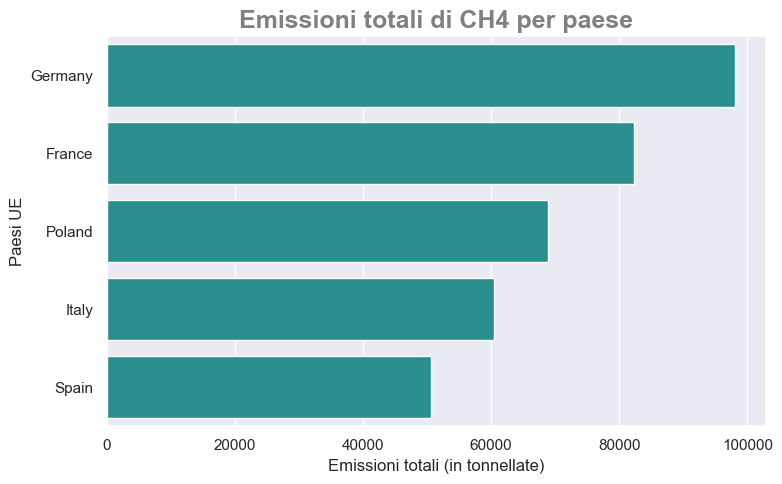

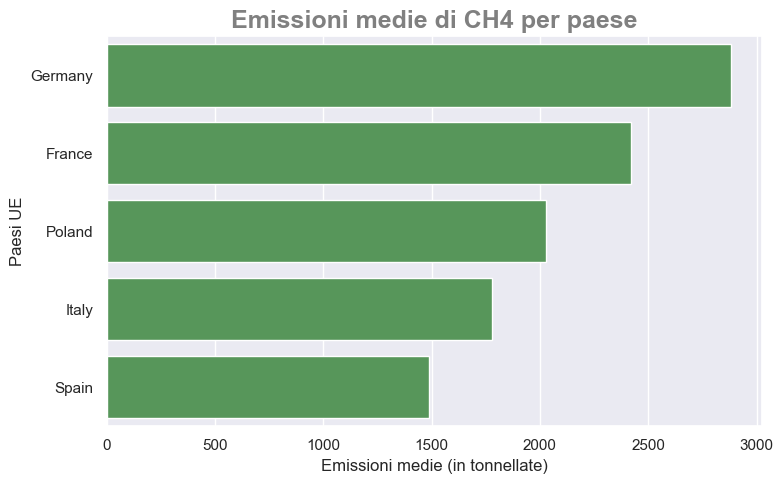

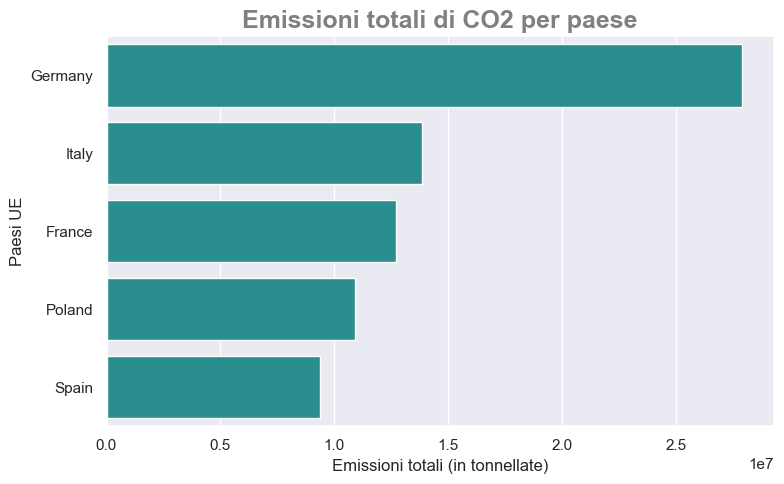

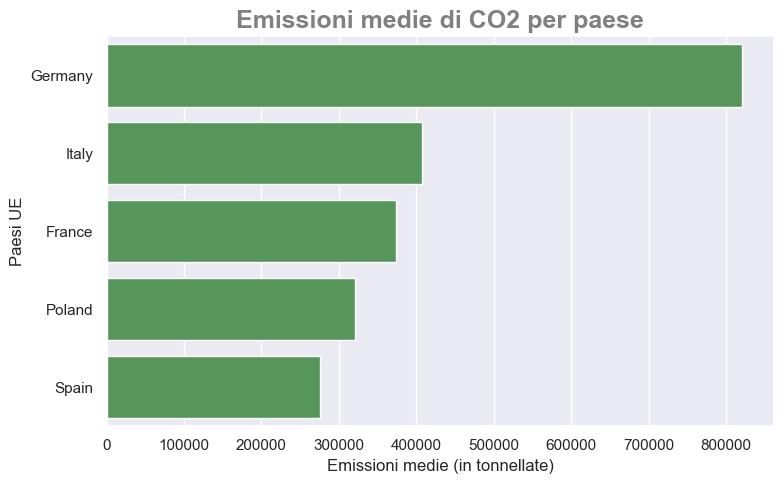

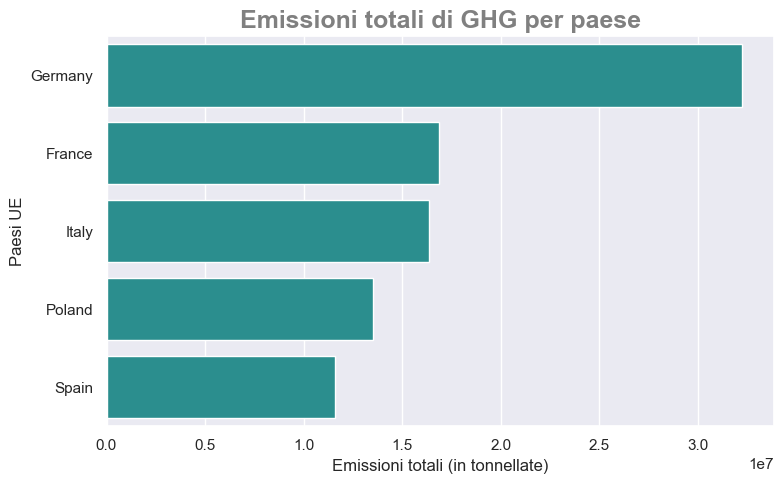

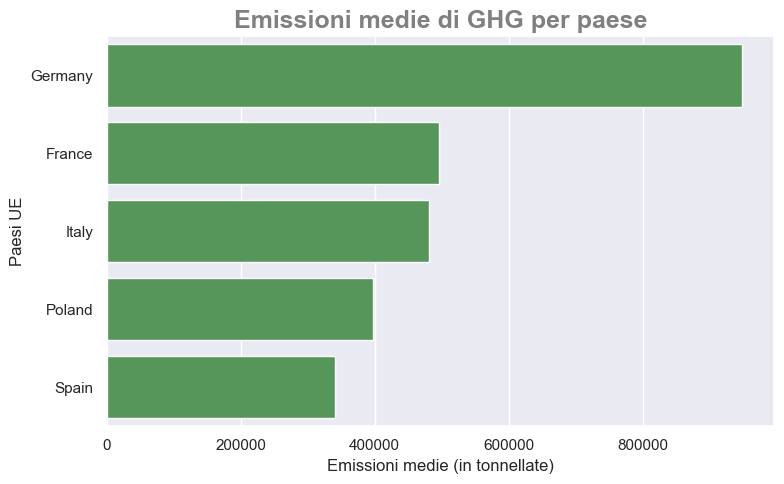

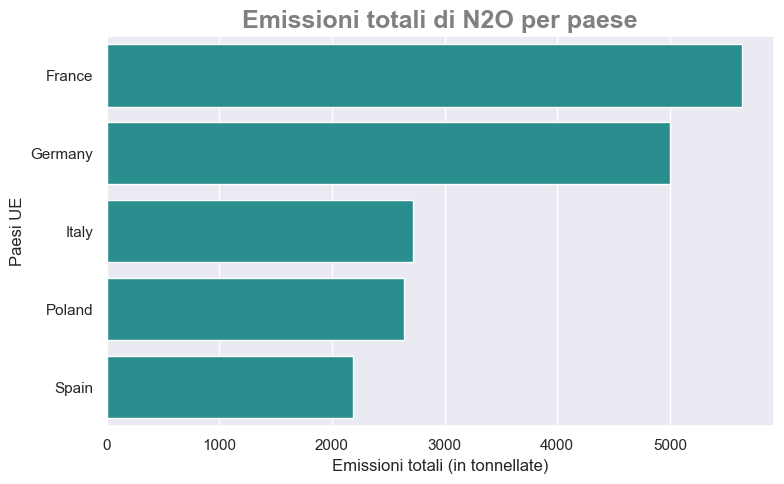

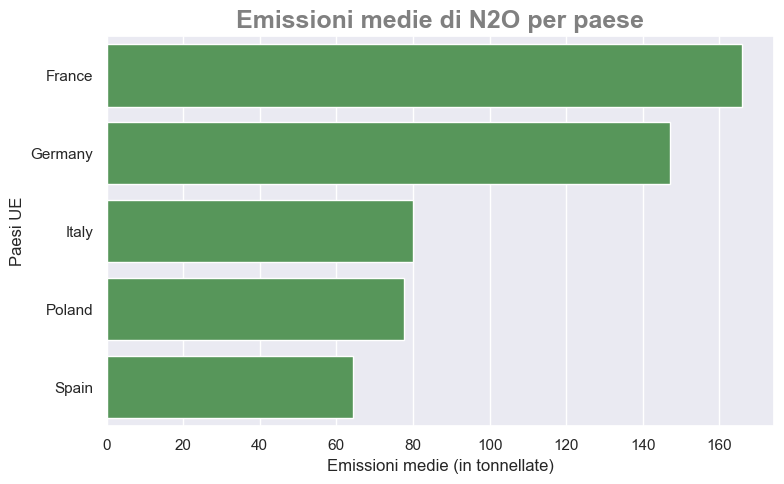

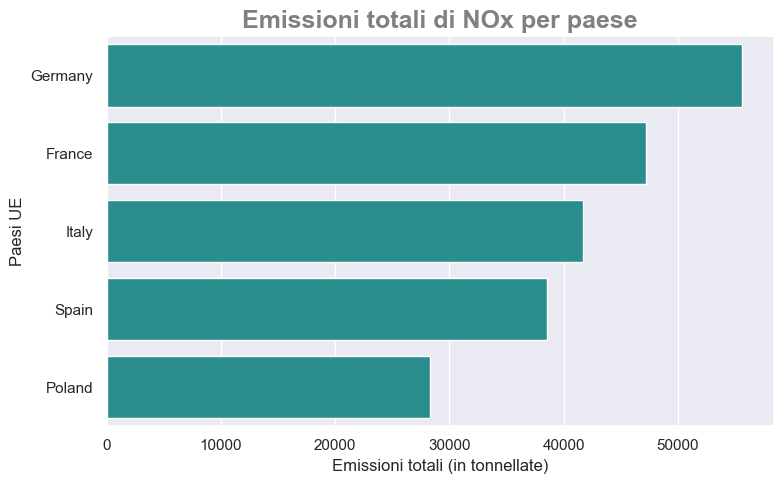

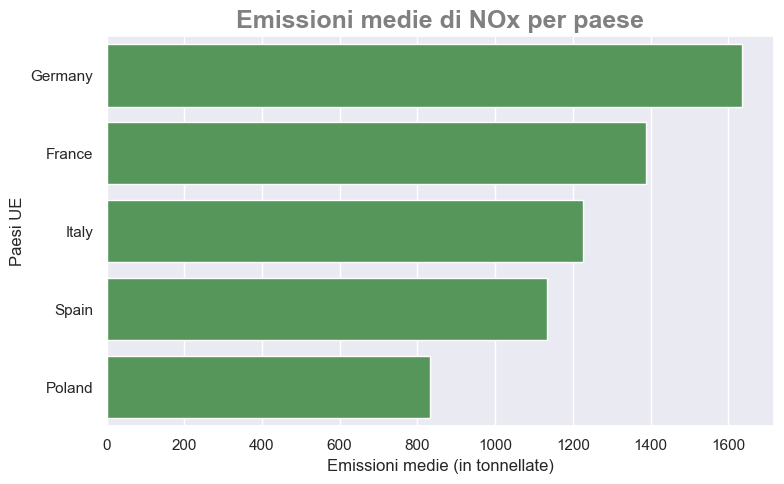

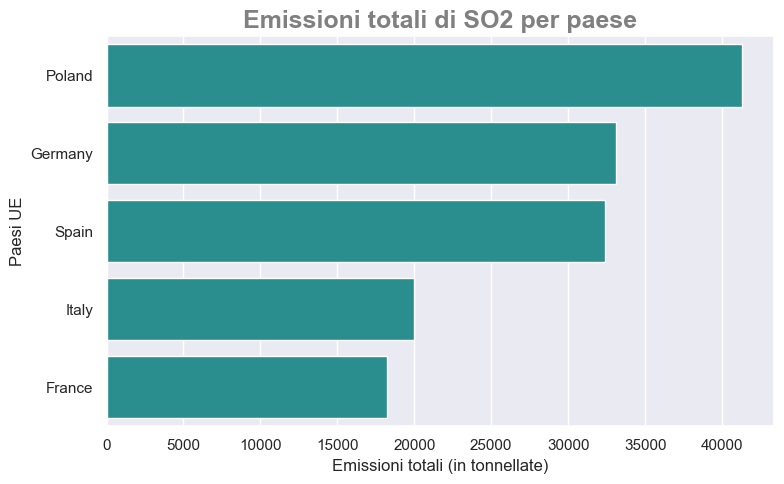

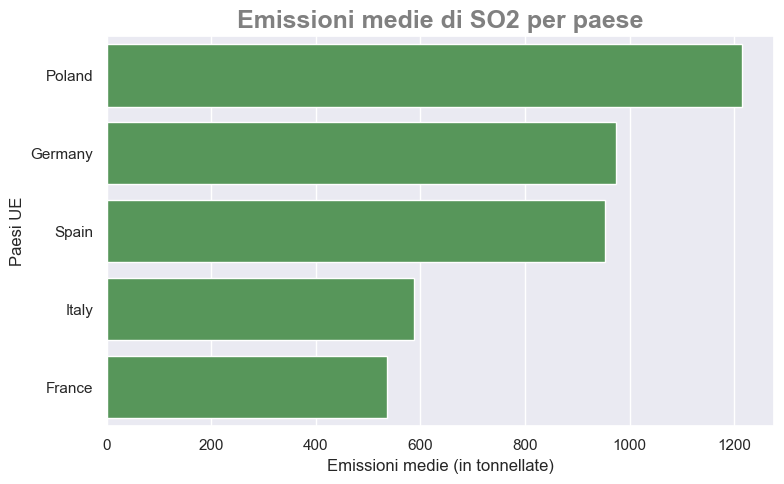

In [18]:
df_emissions_clean = {} # Nuovo dizionario che conterrà i dataframe puliti e con le colonne Total ed Average Emissions
#conversion_report = {}

for gas, df in df_emissions_eu.items():
    df_clean, cols_converted = convert_values_to_numeric(df)
    df_emissions_clean[gas] = calculate_emissions(df_clean,cols_converted)
    #conversion_report[gas] = cols_converted
    
    # Ordiniamo per totale delle emissioni e selezioniamo solo i primi 5 paesi
    sorted = df_emissions_clean[gas].sort_values(by='TotalEmissions', ascending=False).head(5)

    # Istogramma totale delle emissioni
    # subplot per avere tutto in una visualizzazione(?)
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data = sorted,
        x = 'TotalEmissions',
        y = 'Country',
        color='#1B9E9E'
    )
    plt.title(f'Emissioni totali di {gas} per paese', fontsize=18, fontweight='bold', color='grey')
    plt.xlabel('Emissioni totali (in tonnellate)')
    plt.ylabel('Paesi UE')
    plt.tight_layout()
    plt.show()

    # Istogramma media delle emissioni
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data = sorted,
        x = 'AverageEmissions',
        y = 'Country',
        # hue = 'Country', per fare la scala di colori 
        color="#4DA051"
    )
    plt.title(f'Emissioni medie di {gas} per paese', fontsize=18, fontweight='bold', color='grey')
    plt.xlabel('Emissioni medie (in tonnellate)')
    plt.ylabel('Paesi UE')
    plt.tight_layout()
    plt.show()
    # print(sorted_tot.head())






### Trend delle Emissioni di Gas Serra dal 1990 al 2023

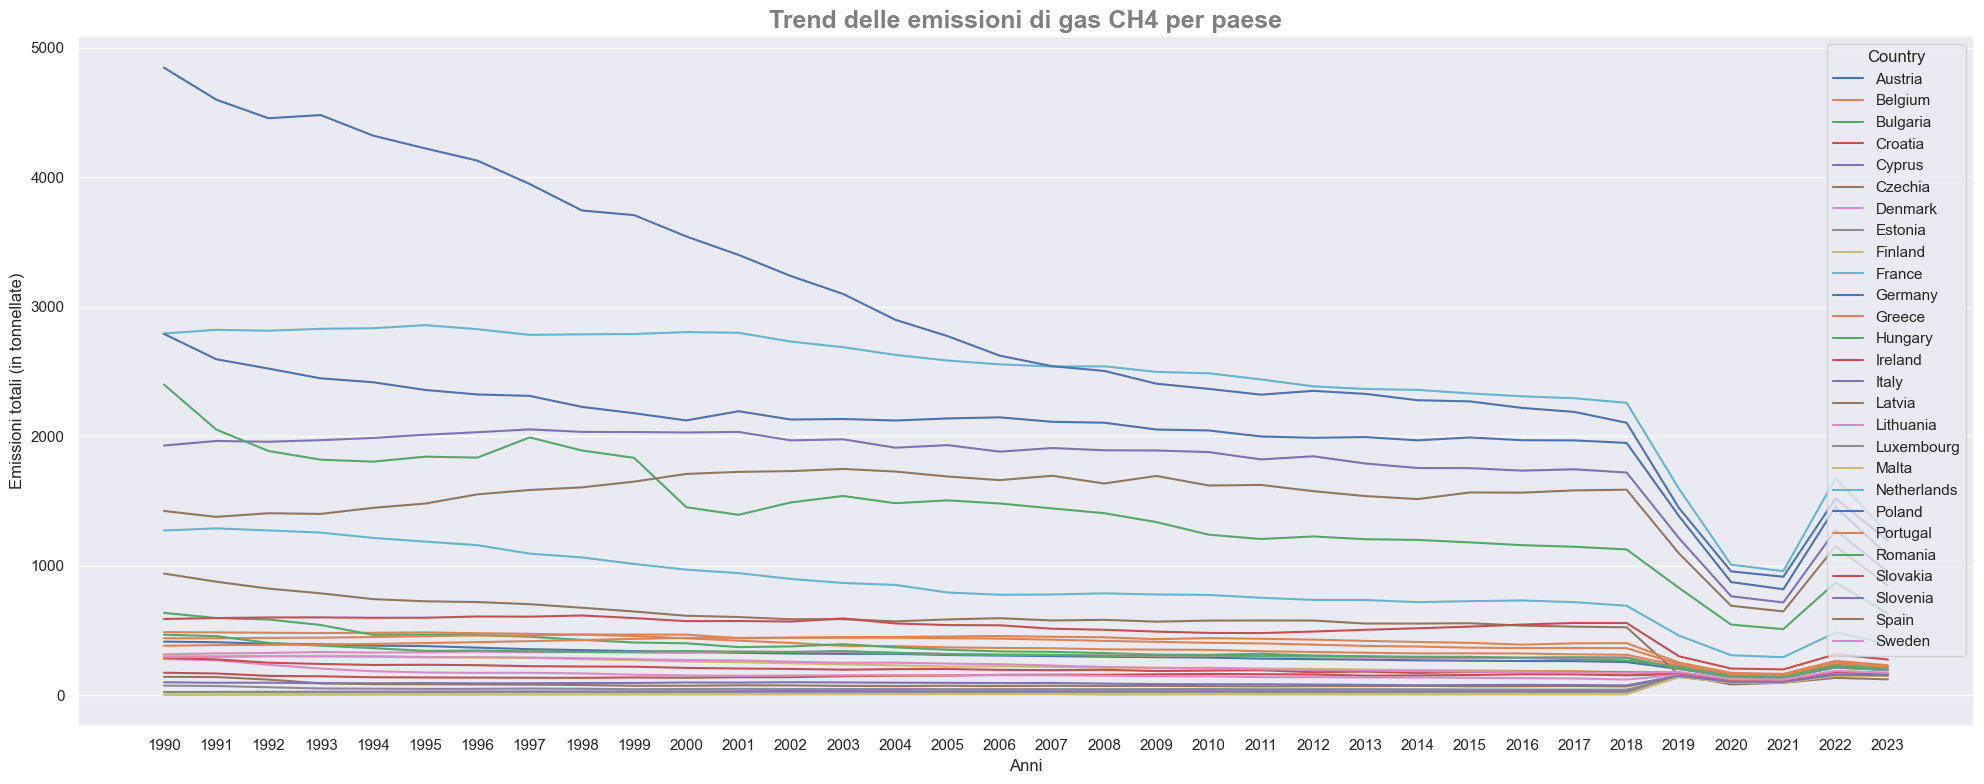

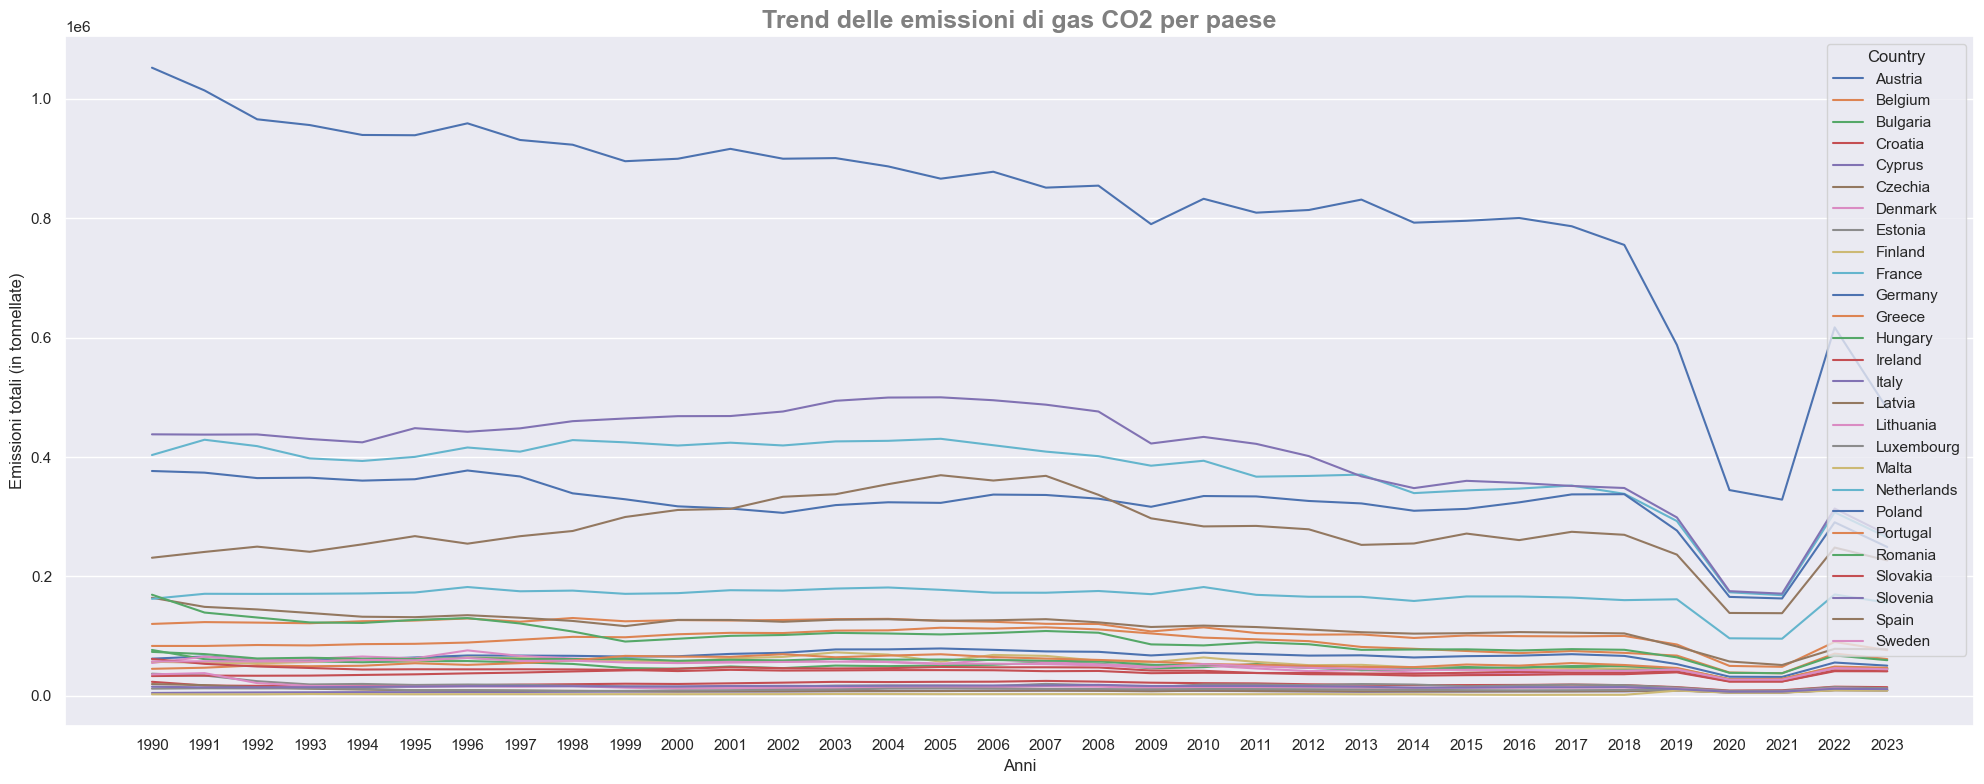

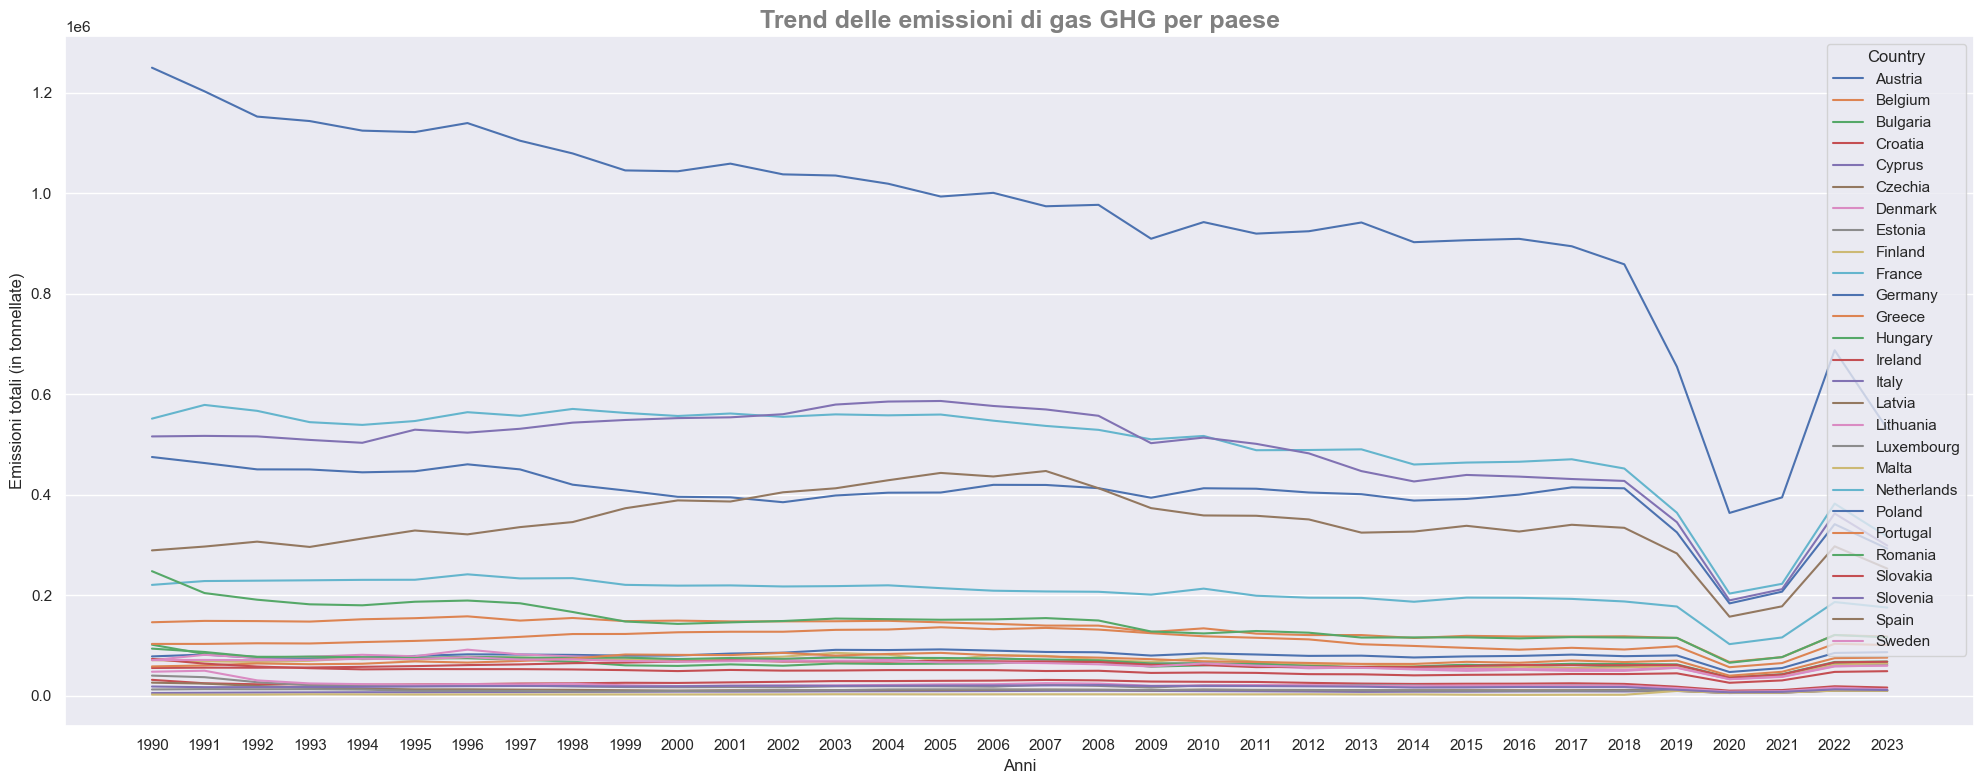

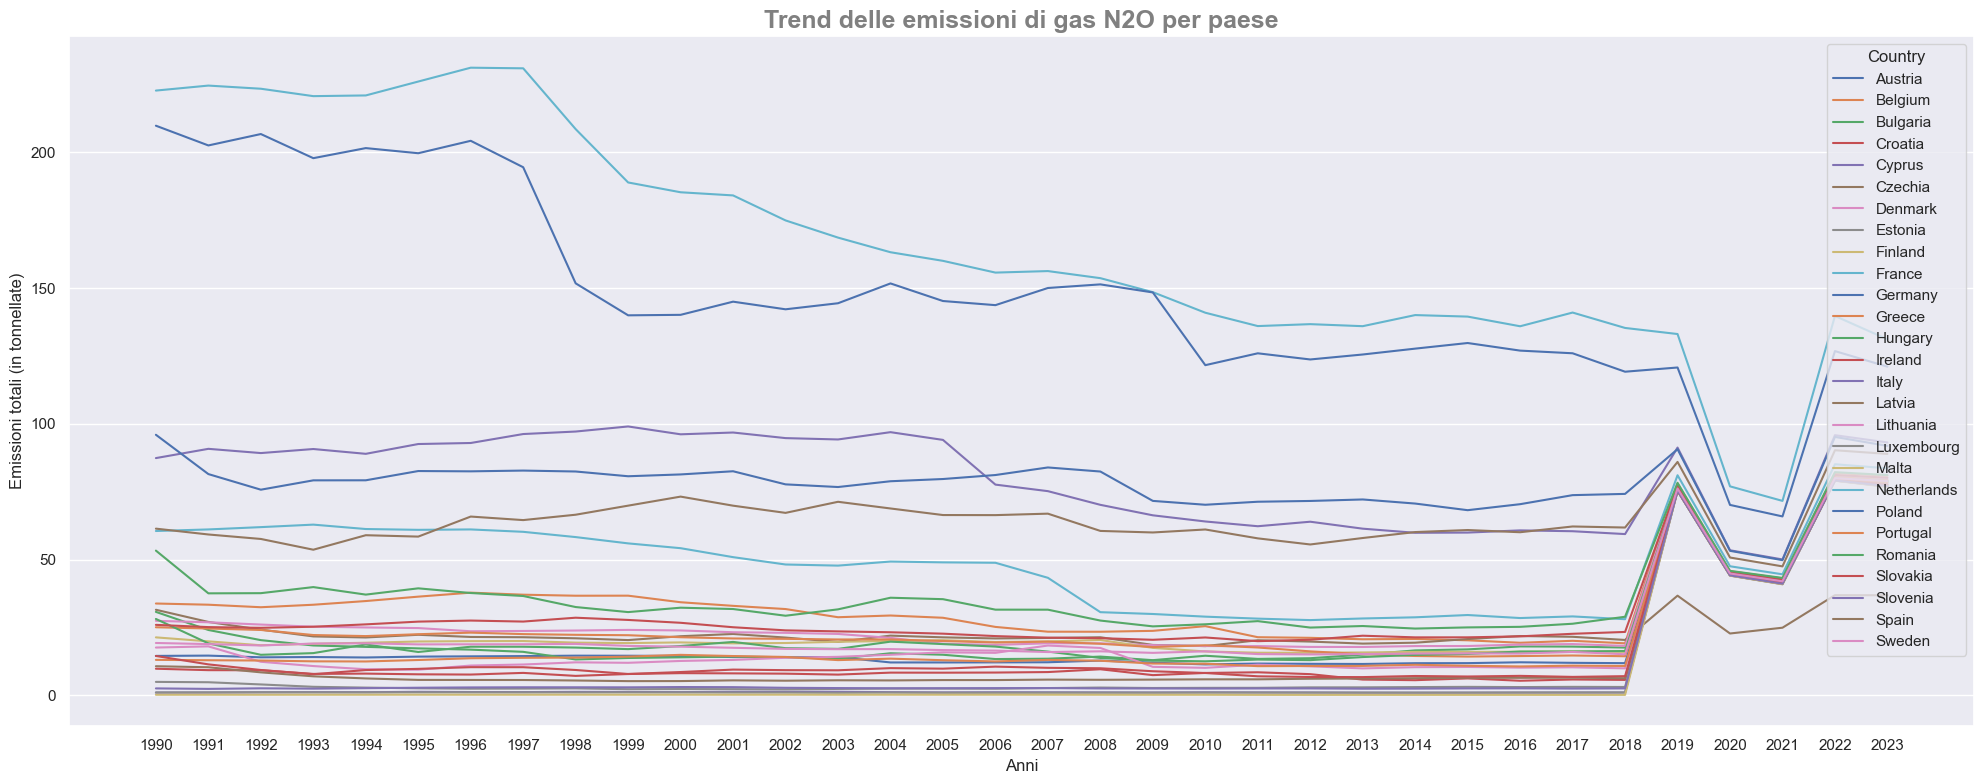

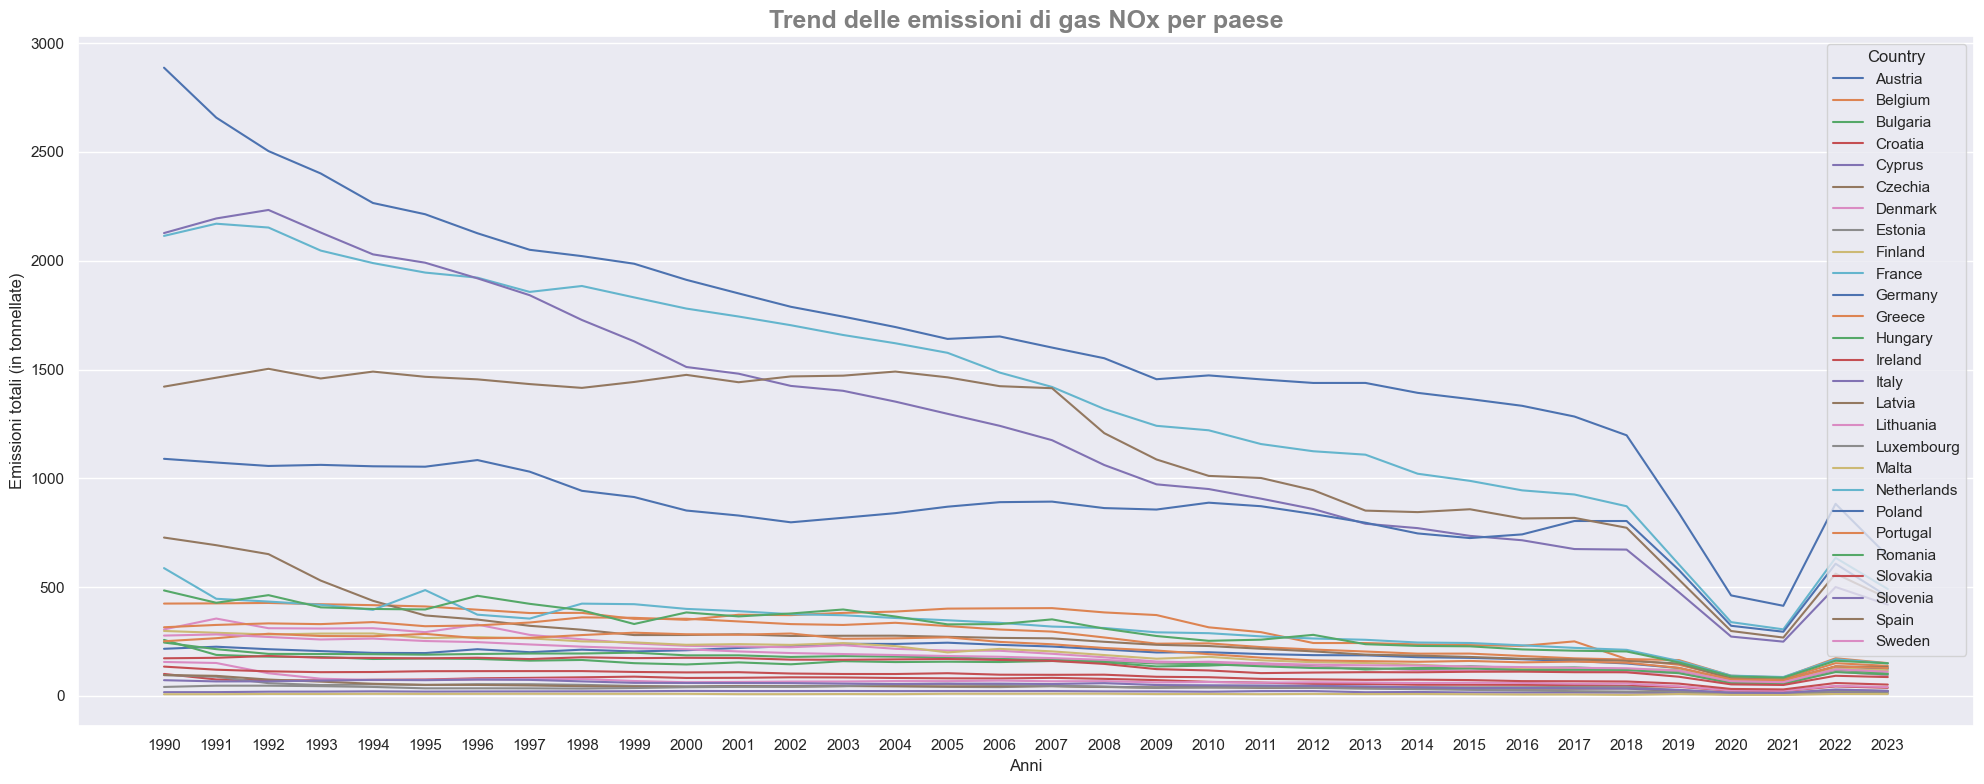

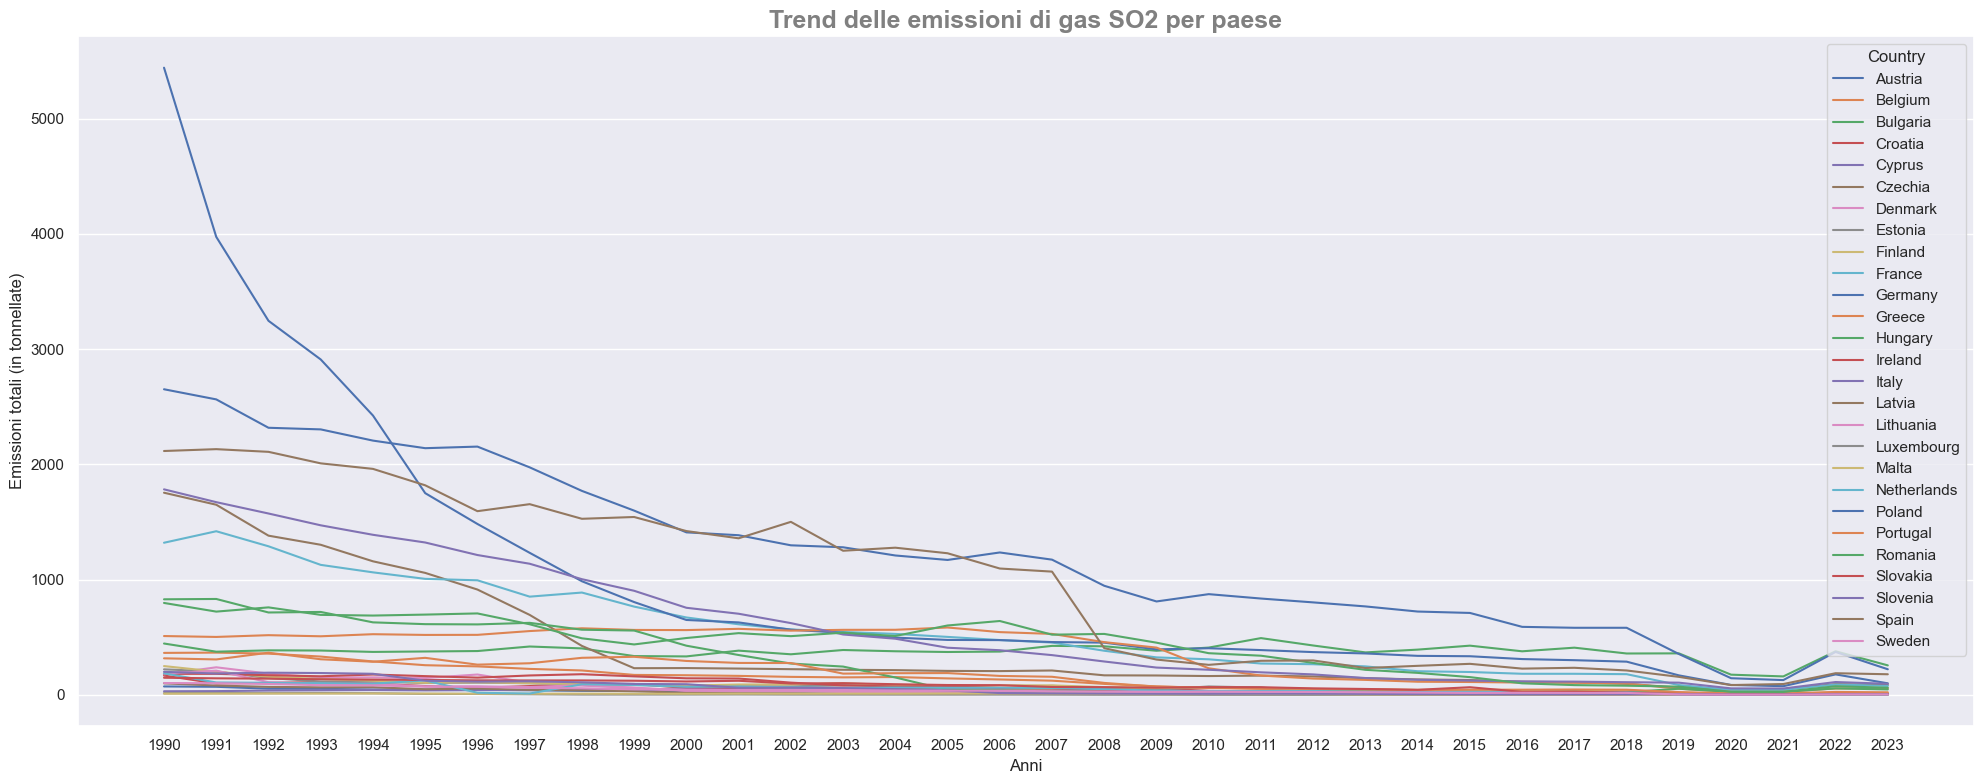

In [19]:
for gas, df in df_emissions_eu.items():
    plot_trend_by_country(df_emissions_clean[gas], gas)

### Analisi della correlazione tra energie rinnovabili e riduzione delle emissioni.

Caricamento del dataset sulle Energie Rinnovabili.

In [20]:
try:
      path = 'Dataset/Renewable_Electricity_Production_Dataset.csv'
      df_r = pd.read_csv(path)
      print(f"Il dataset è stato caricato con successo. Dimensioni: {df_r.shape}")
except FileNotFoundError:
      print(f"Il file {path} non è stato trovato.")


df_r.head()

Il dataset è stato caricato con successo. Dimensioni: (224, 35)


Country and area   1990    1991    1992    1993    1994    1995    1996  \
0      Afghanistan  67.73   67.98   67.99   68.35   68.70   69.04   70.37   
1          Albania  87.61   95.07   95.89   95.12   96.62   95.24   96.63   
2          Algeria   0.84    1.69    1.09    1.82    0.83    0.98    0.63   
3          Andorra  100.0  100.00  100.00  100.00  100.00  100.00  100.00   
4           Angola  86.21   82.66   88.70   93.68   93.72   93.75   89.98   

     1997    1998  ...    2014    2015    2016    2017   2018   2019   2020  \
0   72.39   74.44  ...   85.32   86.07   86.15   84.70    NaN    NaN    NaN   
1   96.99   97.10  ...  100.00  100.00  100.00  100.78  100.0  99.74  99.71   
2    0.35    0.42  ...    0.40    0.32    0.25    0.84    NaN    NaN    NaN   
3  100.00  100.00  ...   88.98   86.87   84.85   83.82   84.5  83.92  83.95   
4   76.35   80.42  ...   53.18   53.18   56.12   71.40    NaN    NaN    NaN   

     2021   2022    2023  
0     NaN    NaN     NaN  
1  100.00  99.79  100.00  
2     NaN    NaN     NaN  
3   83.74  83.35   83.34  
4     NaN    NaN     NaN  

[5 rows x 35 columns]

Pulizia e filtraggio del dataset

In [21]:
# Rinominiamo la colonna 'Country and area' in 'Country'
renewable_df = df_r.copy()
renewable_df.rename(columns={'Country and area': 'Country'}, inplace=True)
renewable_df.head(10)

Country   1990    1991    1992    1993    1994    1995    1996  \
0          Afghanistan  67.73   67.98   67.99   68.35   68.70   69.04   70.37   
1              Albania  87.61   95.07   95.89   95.12   96.62   95.24   96.63   
2              Algeria   0.84    1.69    1.09    1.82    0.83    0.98    0.63   
3              Andorra  100.0  100.00  100.00  100.00  100.00  100.00  100.00   
4               Angola  86.21   82.66   88.70   93.68   93.72   93.75   89.98   
5             Anguilla   0.00    0.00    0.00    0.00    0.00    0.00    0.00   
6  Antigua and Barbuda   0.00    0.00    0.00    0.00    0.00    0.00    0.00   
7            Argentina  35.62   30.40   34.78   39.05   42.12   40.23   32.90   
8              Armenia    NaN     NaN   33.80   68.19   62.11   34.51   25.31   
9                Aruba   0.00    0.00    0.00    0.00    0.00    0.00    0.00   

     1997    1998  ...    2014    2015    2016    2017   2018   2019   2020  \
0   72.39   74.44  ...   85.32   86.07   86.15   84.70    NaN    NaN    NaN   
1   96.99   97.10  ...  100.00  100.00  100.00  100.78  100.0  99.74  99.71   
2    0.35    0.42  ...    0.40    0.32    0.25    0.84    NaN    NaN    NaN   
3  100.00  100.00  ...   88.98   86.87   84.85   83.82   84.5  83.92  83.95   
4   76.35   80.42  ...   53.18   53.18   56.12   71.40    NaN    NaN    NaN   
5    0.00    0.00  ...    0.00    0.00    0.96    0.00    NaN    NaN    NaN   
6    0.00    0.00  ...    0.59    2.02    2.55    2.55    NaN    NaN    NaN   
7   38.62   35.76  ...   30.29   28.94   26.37   29.03    NaN    NaN    NaN   
8   23.08   24.83  ...   25.75   28.34   32.17   29.28    NaN    NaN    NaN   
9    0.00    0.00  ...   15.05   14.81   14.57   14.11    NaN    NaN    NaN   

     2021   2022    2023  
0     NaN    NaN     NaN  
1  100.00  99.79  100.00  
2     NaN    NaN     NaN  
3   83.74  83.35   83.34  
4     NaN    NaN     NaN  
5     NaN    NaN     NaN  
6     NaN    NaN     NaN  
7     NaN    NaN     NaN  
8     NaN    NaN     NaN  
9     NaN    NaN     NaN  

[10 rows x 35 columns]

In [22]:
# Filtraggio per selezionare solo i paesi dell'UE
renewable_df_filtered = filter_eu_countries(renewable_df)
print(f"Dimensioni:{renewable_df_filtered.shape}")
renewable_df_filtered.head()

Dimensioni:(27, 35)


Country   1990   1991   1992   1993   1994   1995   1996   1997   1998  \
0   Austria  64.63  63.60  70.52  72.03  69.13  67.79  64.74  65.51  67.19   
1   Belgium   1.27   1.37   1.61   1.45   1.65   1.67   1.59   1.63   1.81   
2  Bulgaria   4.46   5.97   5.79   5.11   3.85   5.54   6.83   6.86   7.98   
3   Croatia    NaN    NaN  48.85  47.57  61.95  61.27  70.38  57.22  52.61   
4    Cyprus    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ...   2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  ...  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  ...  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  ...  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  ...  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4  ...   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67  

[5 rows x 35 columns]

In [23]:
renewable_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  27 non-null     object 
 1   1990     17 non-null     object 
 2   1991     18 non-null     float64
 3   1992     25 non-null     float64
 4   1993     25 non-null     float64
 5   1994     25 non-null     float64
 6   1995     25 non-null     float64
 7   1996     25 non-null     float64
 8   1997     25 non-null     float64
 9   1998     25 non-null     float64
 10  1999     25 non-null     float64
 11  2000     25 non-null     float64
 12  2001     25 non-null     float64
 13  2002     25 non-null     float64
 14  2003     25 non-null     float64
 15  2004     25 non-null     float64
 16  2005     27 non-null     float64
 17  2006     27 non-null     float64
 18  2007     27 non-null     float64
 19  2008     27 non-null     float64
 20  2009     27 non-null     float64
 21  2010     27 non-nu

Si può notare che solo dal 2005 si hanno informazioni su tutti i Paesi dell'Unione Europea, negli anni precedenti sono presenti valori nulli. Quindi decidiamo di far partire l'analisi dal 2005 in poi.

In [24]:
renew_2005 = get_2005_data_and_above(renewable_df_filtered)
# Creazione del dataset contenente i dati sulle energie rinnovabili a partire dal 2005
cleaned_renewable_df = renewable_df_filtered[['Country']+renew_2005]
cleaned_renewable_df.head()

Country   2005   2006   2007   2008   2009   2010   2011   2012   2013  \
0   Austria  61.04  61.91  63.42  63.91  66.13  61.48  60.63  69.57  72.57   
1   Belgium   2.41   2.63   2.73   3.16   3.29   3.97   5.58   8.18  10.10   
2  Bulgaria  10.67  10.03   7.58   7.55  10.03  13.72   9.21  12.73  17.23   
3   Croatia  54.33  51.81  38.55  46.01  56.10  62.88  47.16  49.56  65.86   
4    Cyprus   0.02   0.02   0.04   0.06   0.08   0.71   2.56   4.39   6.48   

    2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67

#### Top Paesi Virtuosi sulle Energie Rinnovabili al 2023

Visualizziamo i Paesi più virtuosi in materia sulle Energie Rinnovabili al 2023.

In [25]:
# Selezione dei soli dati del 2023
renew_2023 = cleaned_renewable_df[['Country', '2023']].copy().sort_values(by='2023', ascending=False)
renew_2023.head()

Country   2023
17  Luxembourg  78.47
0      Austria  70.48
16   Lithuania  68.26
15      Latvia  59.84
3      Croatia  57.59

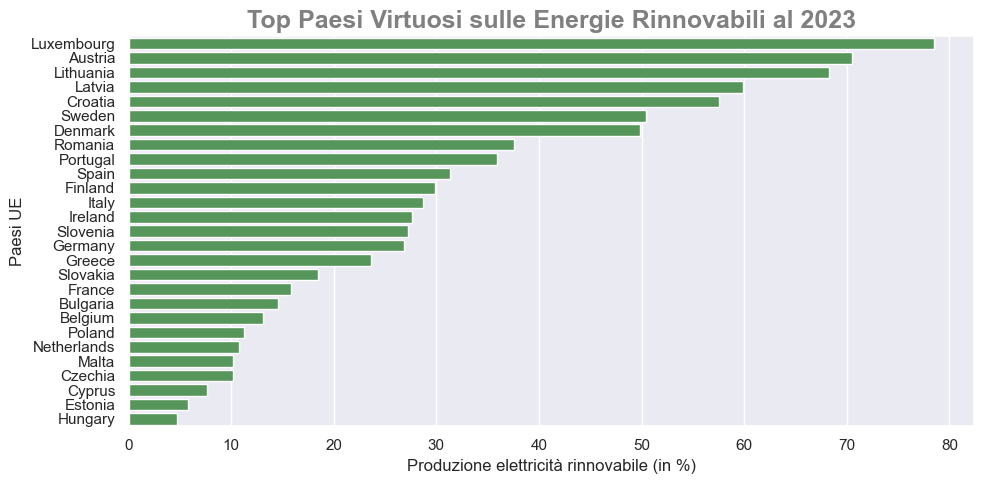

In [26]:
# Visualizzazione dei dati in ordine crescente
plt.figure(figsize=(10, 5))
sns.barplot(
    data = renew_2023,
    x = '2023',
    y = 'Country',
    color="#4DA051"
)
plt.title(f'Top Paesi Virtuosi sulle Energie Rinnovabili al 2023', fontsize=18, fontweight='bold', color='grey')
plt.xlabel('Produzione elettricità rinnovabile (in %)')
plt.ylabel('Paesi UE')
plt.tight_layout()
plt.show()

#### Trend della Produzione di Elettricità da Fonti Rinnovabili per Paese dal 2005 al 2023

Visualizziamo il trend negli anni di produzione di elettricità da fonti rinnovabili per ogni Paese.

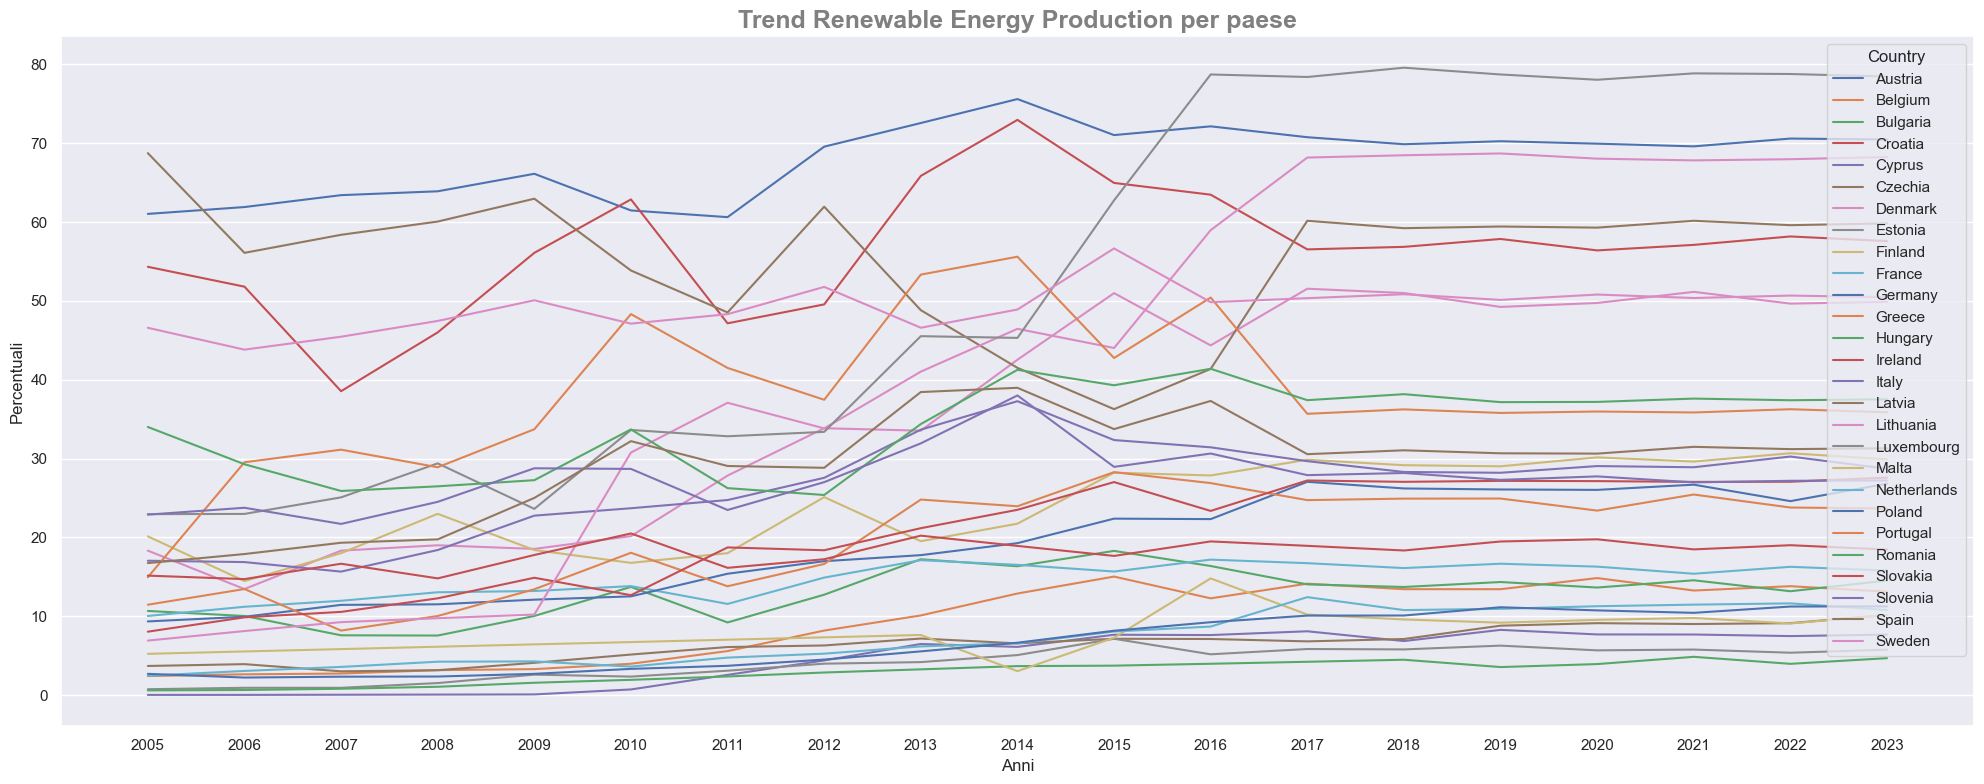

In [27]:
plt.figure(figsize=(20,8))
for country in cleaned_renewable_df['Country']: # Plot di una linea per paese
    data = cleaned_renewable_df[cleaned_renewable_df['Country']==country]
    sns.lineplot(x = cleaned_renewable_df.columns[1:], 
                y= data.iloc[0, 1:],
                label=country)
plt.title(f'Trend Renewable Energy Production per paese', fontsize=18, fontweight='bold', color='grey')
plt.xlabel('Anni')
plt.ylabel('Percentuali')
plt.legend(title='Country', loc='upper right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Correlazione tra Energie Rinnovabili ed Emissioni di Gas Serra

Vediamo se c'è una correlazione tra l'utilizzo di Energie Rinnovabili e le Emissioni di Gas Serra.

In [28]:
correlation_results = {}

merged_data = {}

for gas, df in df_emissions_eu.items():
    df_merge, corr = calculate_correlation(df, gas, cleaned_renewable_df)
    correlation_results[gas] = corr
    merged_data[gas] = df_merge

La correlazione tra Energie Rinnovabili e CH4 è -0.21
La correlazione tra Energie Rinnovabili e CO2 è -0.21
La correlazione tra Energie Rinnovabili e GHG è -0.22
La correlazione tra Energie Rinnovabili e N2O è -0.20
La correlazione tra Energie Rinnovabili e NOx è -0.18
La correlazione tra Energie Rinnovabili e SO2 è -0.30


Poichè i valori del CO2 e del GHG sono molto fuori scala rispetto agli altri conviene riportarli in un grafico separato.

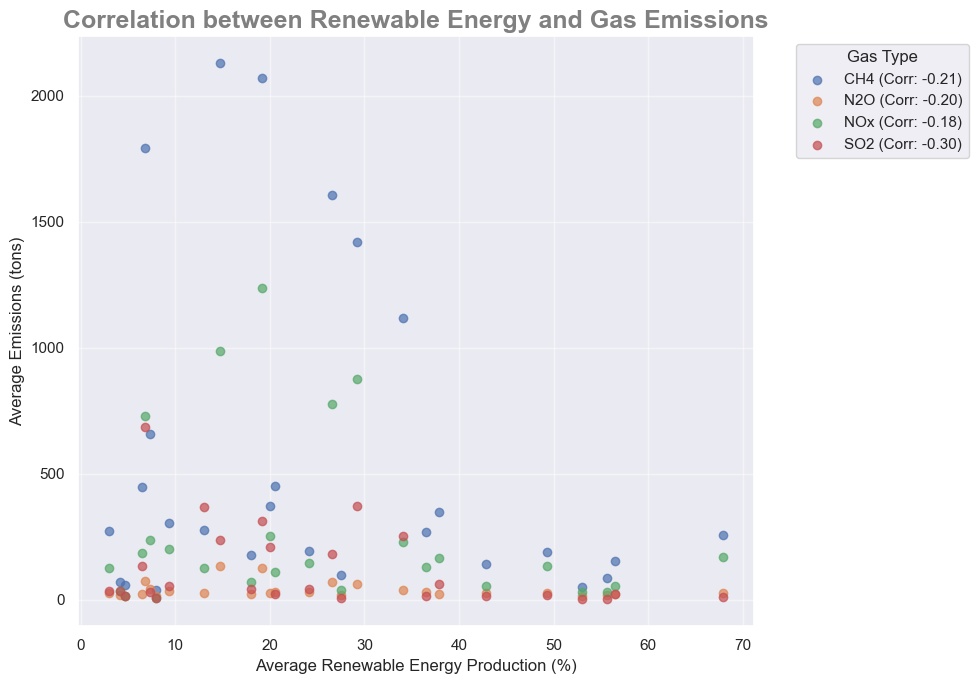

In [29]:
plt.figure(figsize=(10, 7))

for gas in merged_data.keys():
    if gas != 'CO2' and gas != 'GHG':
        df_corr = merged_data[gas]
        corr_value = correlation_results[gas]

        plt.scatter(
            df_corr['Renewable_Energy_Mean'],
            df_corr['AverageEmissions'],
            label=f'{gas} (Corr: {corr_value:.2f})',
            alpha=0.7
        )

plt.title(
    'Correlation between Renewable Energy and Gas Emissions',
    fontsize=18, fontweight='bold', color='grey'
)
plt.xlabel('Average Renewable Energy Production (%)', fontsize=12)
plt.ylabel('Average Emissions (tons)', fontsize=12)

plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


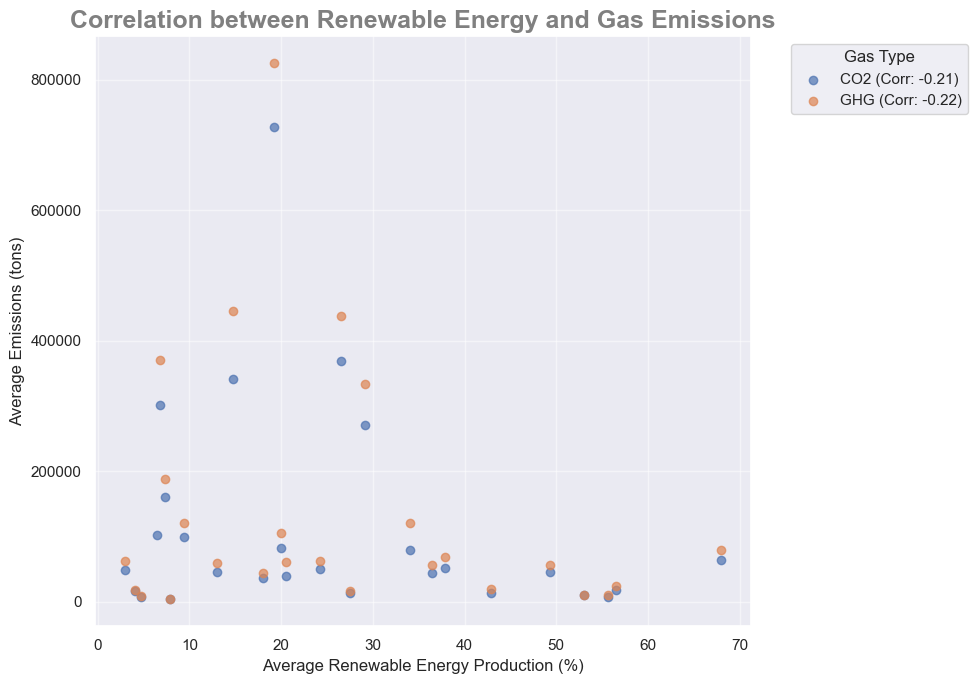

In [30]:
plt.figure(figsize=(10, 7))

for gas in merged_data.keys():
    if gas == 'CO2' or gas == 'GHG':
        df_corr = merged_data[gas]
        corr_value = correlation_results[gas]

        plt.scatter(
            df_corr['Renewable_Energy_Mean'],
            df_corr['AverageEmissions'],
            label=f'{gas} (Corr: {corr_value:.2f})',
            alpha=0.7
        )

plt.title(
    'Correlation between Renewable Energy and Gas Emissions',
    fontsize=18, fontweight='bold', color='grey'
)
plt.xlabel('Average Renewable Energy Production (%)', fontsize=12)
plt.ylabel('Average Emissions (tons)', fontsize=12)

plt.legend(title='Gas Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

## **Analisi predittive**

Qual è il futuro della sostenibilità ambientale fino al 2035?

Prediciamo la produzione di CO2 dei Paesi dell'Unione e la produzione di energia da fonti rinnovabili.

### Predizione sulla produzione di CO2 dei Paesi dellʼUnione Europea al 2035

In [31]:
# Dati disponibili sulla produzione di CO2
df_emissions_eu['CO2'].tail()

Country       1990       1991       1992       1993       1994  \
22   Romania  169285.87  139370.25  131072.28  122832.31  121961.46   
23  Slovakia   61633.46   53437.90   49029.14   46484.22   43878.72   
24  Slovenia   15093.84   14001.24   14006.75   14303.47   14642.67   
25     Spain  231213.56  240953.02  249813.19  241195.18  253661.39   
26    Sweden   57348.82   57707.22   57451.49   57493.45   59953.81   

         1995       1996       1997       1998  ...       2014       2015  \
22  127032.86  130095.93  121074.67  107561.54  ...   77432.42   77725.63   
23   44322.41   44186.12   44313.68   44073.14  ...   33654.50   34484.24   
24   15254.25   15916.61   16244.92   15961.13  ...   13531.94   13617.54   
25  267416.72  254795.33  267306.44  276021.58  ...  255100.21  271687.35   
26   59366.21   63302.78   58212.55   58696.67  ...   43337.56   43336.76   

         2016       2017       2018       2019       2020       2021  \
22   75812.80   78077.49   76951.22   64315.82   38356.57   37711.23   
23   34921.79   36087.34   36087.84   39128.92   23663.27   23800.10   
24   14416.66   14264.75   14487.84   11119.68    6634.59    6853.85   
25  260759.56  274671.26  269654.25  236455.77  138683.94  138295.80   
26   42972.57   42306.82   41766.18   44184.39   26765.43   26849.85   

         2022       2023  
22   67531.61   59525.86  
23   41085.37   40948.98  
24   11675.66   10994.74  
25  248278.56  226716.02  
26   46393.61   44346.89  

[5 rows x 35 columns]

#### Regressione Lineare

Un problema di regressione consiste nel prevedere un valore numerico continuo a partire da un insieme di feature.

La regressione lineare è il modello più semplice e intuitivo. Serve per trovare una relazione tra due o più variabili, assumendo che tale relazione sia lineare, cioè rappresentabile da una retta.

In [49]:
# Preprocessing dei dati
df_co2 = df_emissions_eu['CO2'].copy() # creiamo una copia dei dati (storici)
years = np.array([int(year) for year in df_co2.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1, 1)

In [50]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred

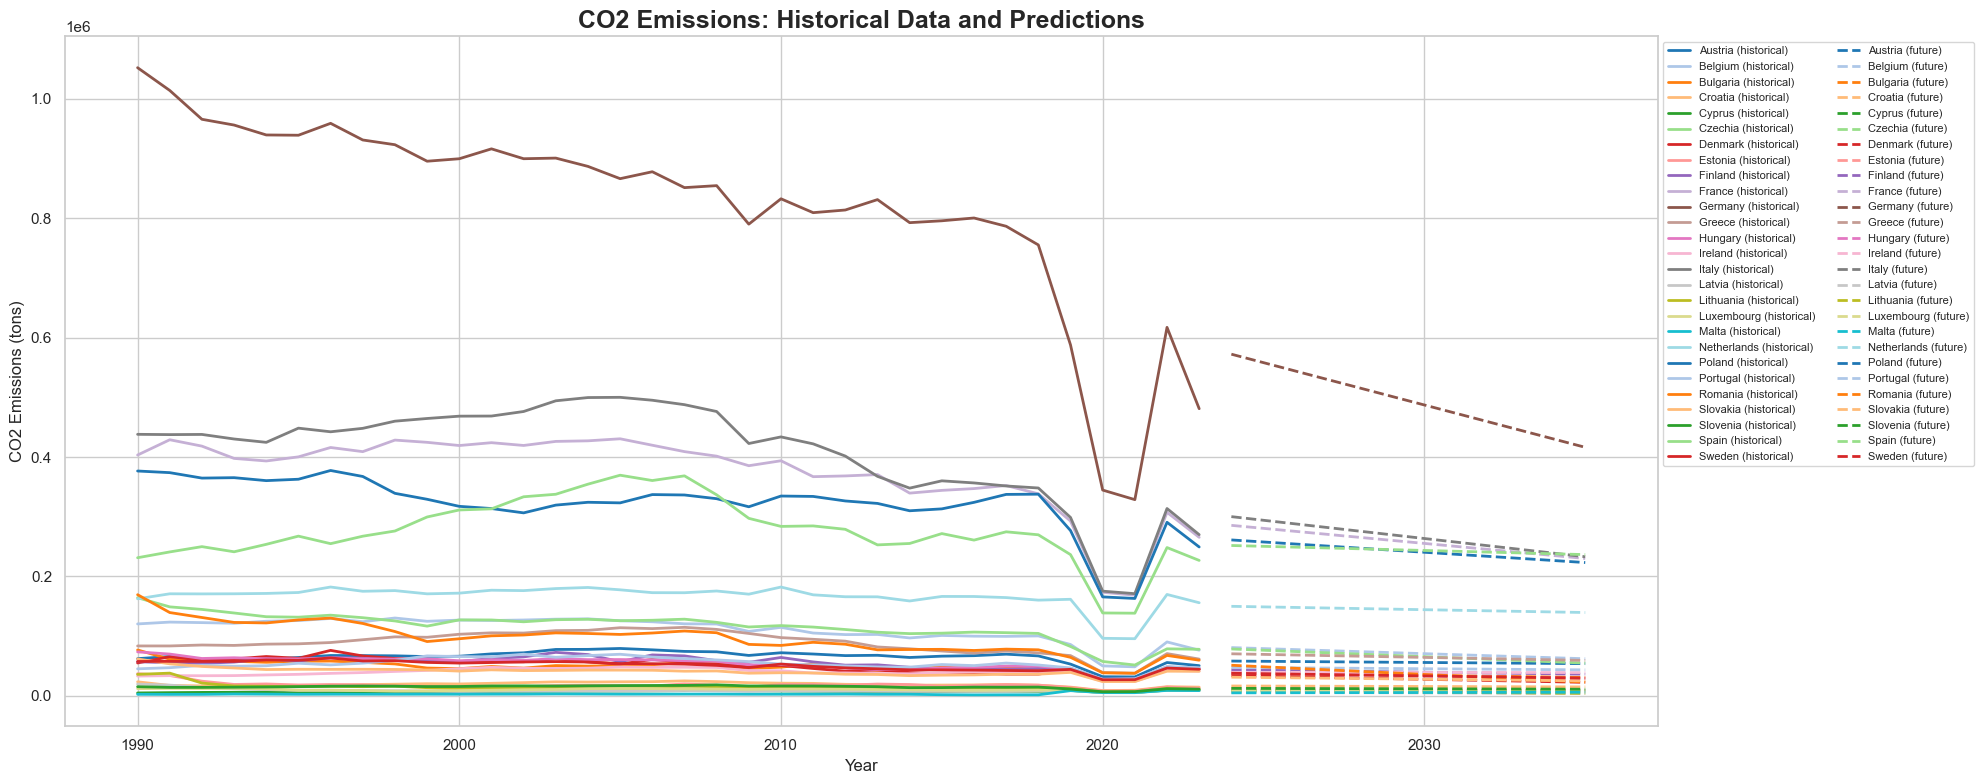

In [51]:
plot_historical_vs_predicted(df_hist=df_co2, df_pred=predictions, title='CO2 Emissions: Historical Data and Predictions', ylabel='CO2 Emissions (tons)', figsize=(20, 8))

In [52]:
# Visualizzazione metriche per valutazione modello
print(metrics_df)

        Country          RMSE        R2
0       Austria   9794.724758  0.134555
1       Belgium  12352.978660  0.645648
2      Bulgaria   5758.002782  0.563676
3       Croatia   3443.809527  0.140745
4        Cyprus    997.912061  0.288493
5       Czechia  10934.613219  0.788213
6       Denmark   6059.601943  0.731392
7       Estonia   4211.393300  0.379060
8       Finland   7731.677096  0.413629
9        France  42881.650945  0.571467
10      Germany  90112.124010  0.704625
11       Greece  16295.264958  0.269919
12      Hungary   4862.535704  0.768604
13      Ireland   5964.575186  0.002095
14        Italy  58113.377776  0.515387
15       Latvia   2322.464983  0.361709
16    Lithuania   4697.268666  0.393876
17   Luxembourg   1527.445965  0.183370
18        Malta   1621.478950  0.243229
19  Netherlands  16303.399181  0.243699
20       Poland  33913.245845  0.498271
21     Portugal   9052.938558  0.138176
22      Romania  11014.103773  0.839795
23     Slovakia   4210.573668  0.625005


#### Regressione Lineare Polinomiale

La regressione polinomiale è una generalizzazione della regressione lineare che, invece di una linea retta, permette di utilizzare curve
(polinomi) per rappresentare la relazione tra variabili.

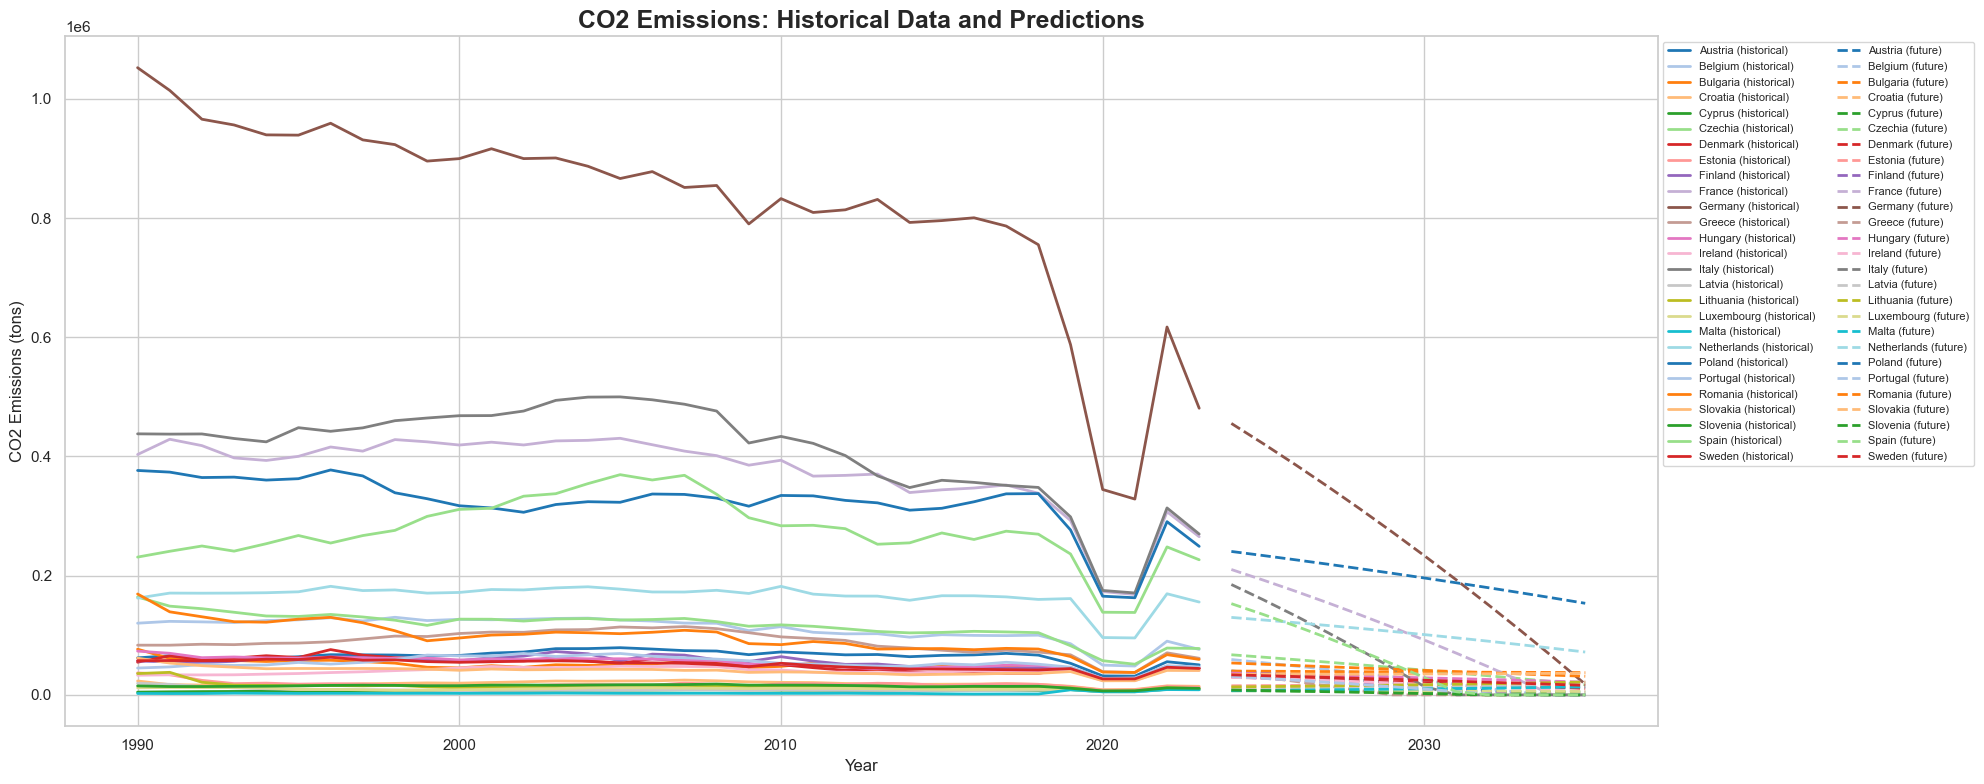

In [54]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # Impostazione valori negativi a zero
    future_pred = np.maximum(future_pred, 0)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred

# Grafico
plot_historical_vs_predicted(df_hist=df_co2, df_pred=predictions, title='CO2 Emissions: Historical Data and Predictions', ylabel='CO2 Emissions (tons)', figsize=(20, 8))

In [55]:
# Visualizzazione metriche per valutazione modello
print(metrics_df_poly)

        Country          RMSE        R2
0       Austria   6424.656257  0.627647
1       Belgium   8731.871800  0.822946
2      Bulgaria   5699.219211  0.572540
3       Croatia   2353.891608  0.598564
4        Cyprus    855.959829  0.476518
5       Czechia   9956.418489  0.824411
6       Denmark   5896.293415  0.745676
7       Estonia   3987.262617  0.443394
8       Finland   5674.342773  0.684168
9        France  29882.136717  0.791904
10      Germany  76373.585669  0.787825
11       Greece   8615.014406  0.795939
12      Hungary   4782.669892  0.776143
13      Ireland   4432.012941  0.449024
14        Italy  34127.690881  0.832869
15       Latvia   1645.768940  0.679478
16    Lithuania   4193.000702  0.517030
17   Luxembourg   1504.492922  0.207729
18        Malta   1349.652055  0.475693
19  Netherlands  14144.170002  0.430762
20       Poland  32871.204249  0.528630
21     Portugal   6099.059992  0.608830
22      Romania  10967.295150  0.841154
23     Slovakia   3977.659675  0.665345


#### LSTM

LSTM è un tipo di rete neurale progettata per lavorare con sequenze di dati. È particolarmente utile per analizzare dati dove lʼordine e la dipendenza temporale tra i valori sono importanti.

In [38]:
# Preprocessing dei dati
def prepare_lstm_data(data, sequence_length):
    '''
    Funzione di preprocessing per lstm.
    Parametri: 
    - data: array o lista contenente i dati da cui estrarre le sequenze temporali
    - sequence_length: lunghezza della sequenza temporale
    '''
    X,y = [],[]
    for i in range(len(data)-sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for country in df_co2['Country']:
    # Estrazione dati storici per Paese
    country_data = df_co2[df_co2['Country']==country].iloc[:,1:].values.flatten()
    years = df_co2.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(country_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions[country] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola

   Year       Austria       Belgium      Bulgaria       Croatia       Cyprus  \
0  2024  49599.464844  78777.898438  42270.671875  14184.350586  7658.032715   
1  2025  49655.984375  78573.648438  42026.417969  14247.008789  7492.765137   
2  2026  51756.699219  81829.765625  43438.718750  14884.668945  7758.364258   
3  2027  54050.964844  85571.257812  45063.292969  15533.313477  8073.297363   
4  2028  54063.960938  85246.664062  44849.562500  15615.498047  7908.176758   

        Czechia       Denmark       Estonia       Finland  ...   Luxembourg  \
0  77480.289062  42888.031250  13790.514648  41791.226562  ...  8488.654297   
1  77527.375000  42724.589844  13946.669922  41478.601562  ...  8448.465820   
2  79903.484375  44203.570312  14377.545898  43095.738281  ...  8698.013672   
3  82969.492188  45930.937500  14774.421875  44846.980469  ...  8954.604492   
4  83675.882812  45810.136719  14848.828125  44456.253906  ...  8896.301758   

         Malta    Netherlands         Poland

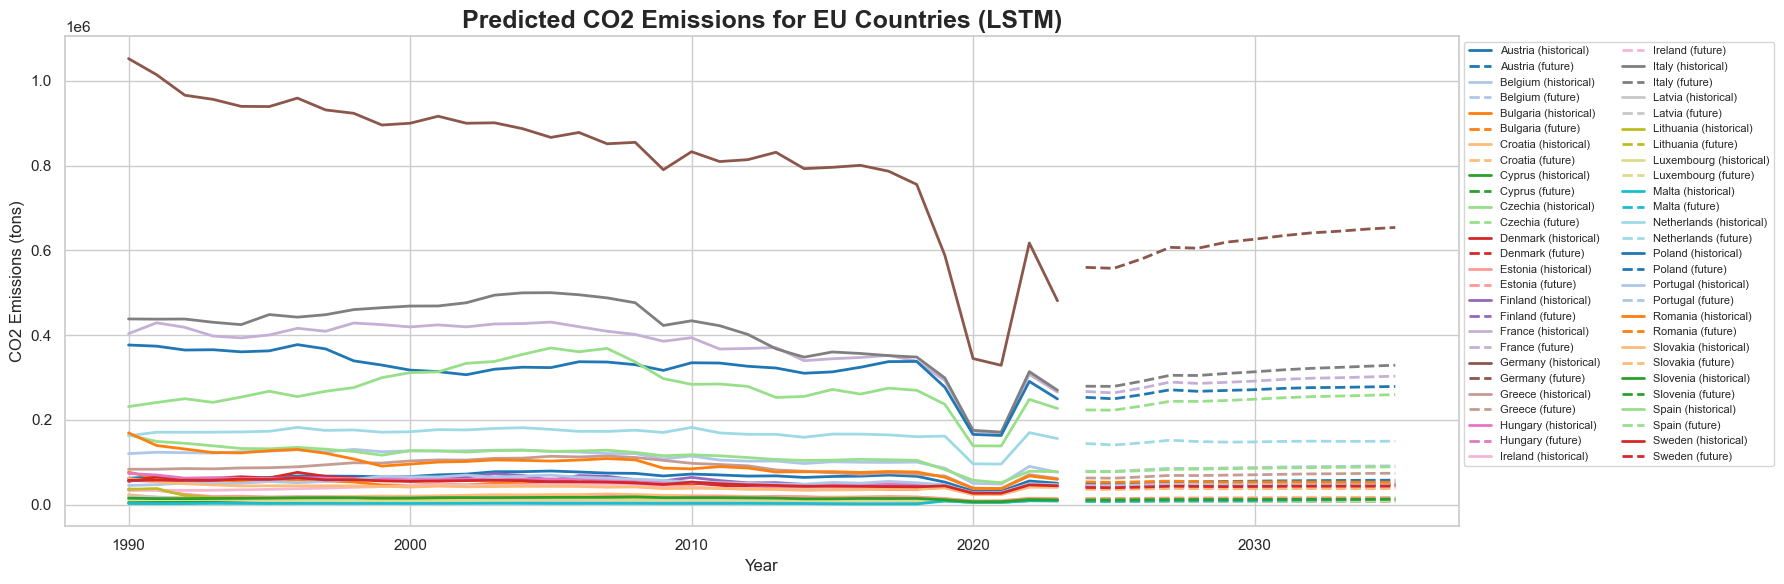

In [39]:
plt.figure(figsize=(18, 6))
sns.set_style("whitegrid")

countries = df_co2['Country']
palette = plt.cm.tab20.colors

color_map = {
    country: palette[i % len(palette)]
    for i, country in enumerate(countries)
}

years_pred = predictions['Year'].values

for country in countries:
    # Dati storici
    hist_values = (df_co2[df_co2['Country'] == country].iloc[0, 1:].values.flatten())

    sns.lineplot(
        x=years,
        y=hist_values,
        color=color_map[country],
        linewidth=2,
        label=f'{country} (historical)'
    )

    # Predizioni future
    sns.lineplot(
        x=years_pred,
        y=predictions[country],
        color=color_map[country],
        linestyle='--',
        linewidth=2,
        label=f'{country} (future)'
    )

plt.title(
    'Predicted CO2 Emissions for EU Countries (LSTM)',
    fontsize=18,
    fontweight='bold'
)
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (tons)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

In [40]:
print(metrics_df_lstm)

        Country           RMSE        R2
0       Austria    9041.322821  0.358496
1       Belgium   13199.471137  0.633218
2      Bulgaria    5936.931800  0.290009
3       Croatia    2748.216770  0.490890
4        Cyprus     930.611830  0.159299
5       Czechia   12411.940181  0.667046
6       Denmark    7717.932541  0.566571
7       Estonia    2554.947135  0.191596
8       Finland    7204.172954  0.558771
9        France   44507.541943  0.583832
10      Germany  108091.418691  0.557813
11       Greece   12753.464725  0.616220
12      Hungary    6651.453235  0.499637
13      Ireland    5143.076190  0.236707
14        Italy   52128.040967  0.661258
15       Latvia     871.235693  0.146372
16    Lithuania    1959.233908  0.227122
17   Luxembourg    1434.405772  0.164715
18        Malta    1600.091945  0.355858
19  Netherlands   17688.521776  0.233764
20       Poland   40320.180606  0.273581
21     Portugal    7586.473792  0.450860
22      Romania   11163.811869  0.750053
23     Slovakia 

### Predizione sull'utilizzo di Energie Rinnovabili dei Paesi dell'Unione Europea al 2035


In [58]:
df_renw = cleaned_renewable_df.copy()
years = np.array([int(year) for year in df_renw.columns[1:]]).reshape(-1,1)
future_years = np.array(range(2024, 2036)).reshape(-1, 1)
df_renw.head()

Country   2005   2006   2007   2008   2009   2010   2011   2012   2013  \
0   Austria  61.04  61.91  63.42  63.91  66.13  61.48  60.63  69.57  72.57   
1   Belgium   2.41   2.63   2.73   3.16   3.29   3.97   5.58   8.18  10.10   
2  Bulgaria  10.67  10.03   7.58   7.55  10.03  13.72   9.21  12.73  17.23   
3   Croatia  54.33  51.81  38.55  46.01  56.10  62.88  47.16  49.56  65.86   
4    Cyprus   0.02   0.02   0.04   0.06   0.08   0.71   2.56   4.39   6.48   

    2014   2015   2016   2017   2018   2019   2020   2021   2022   2023  
0  75.61  71.04  72.15  70.77  69.88  70.26  69.95  69.61  70.60  70.48  
1  12.88  15.03  12.27  14.13  13.43  13.43  14.84  13.26  13.81  13.11  
2  16.34  18.29  16.37  14.04  13.71  14.34  13.64  14.56  13.17  14.53  
3  72.97  64.97  63.48  56.54  56.86  57.86  56.41  57.11  58.18  57.59  
4   6.11   7.65   7.61   8.09   6.85   8.27   7.69   7.68   7.48   7.67

#### Regressione Lineare 

In [62]:
# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2036)})

# DataFrame per memorizzare i risulati 
metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Evitare warning su fillna
pd.set_option('future.no_silent_downcasting',True)

# Addestramento di un modello di regressione lineare per ogni paese per predire i valori futuri
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].fillna(0).values.flatten()
    
    # Addestramento modello
    model = LinearRegression()
    model.fit(years, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df.loc[len(metrics_df)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_pred = model.predict(future_years)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred

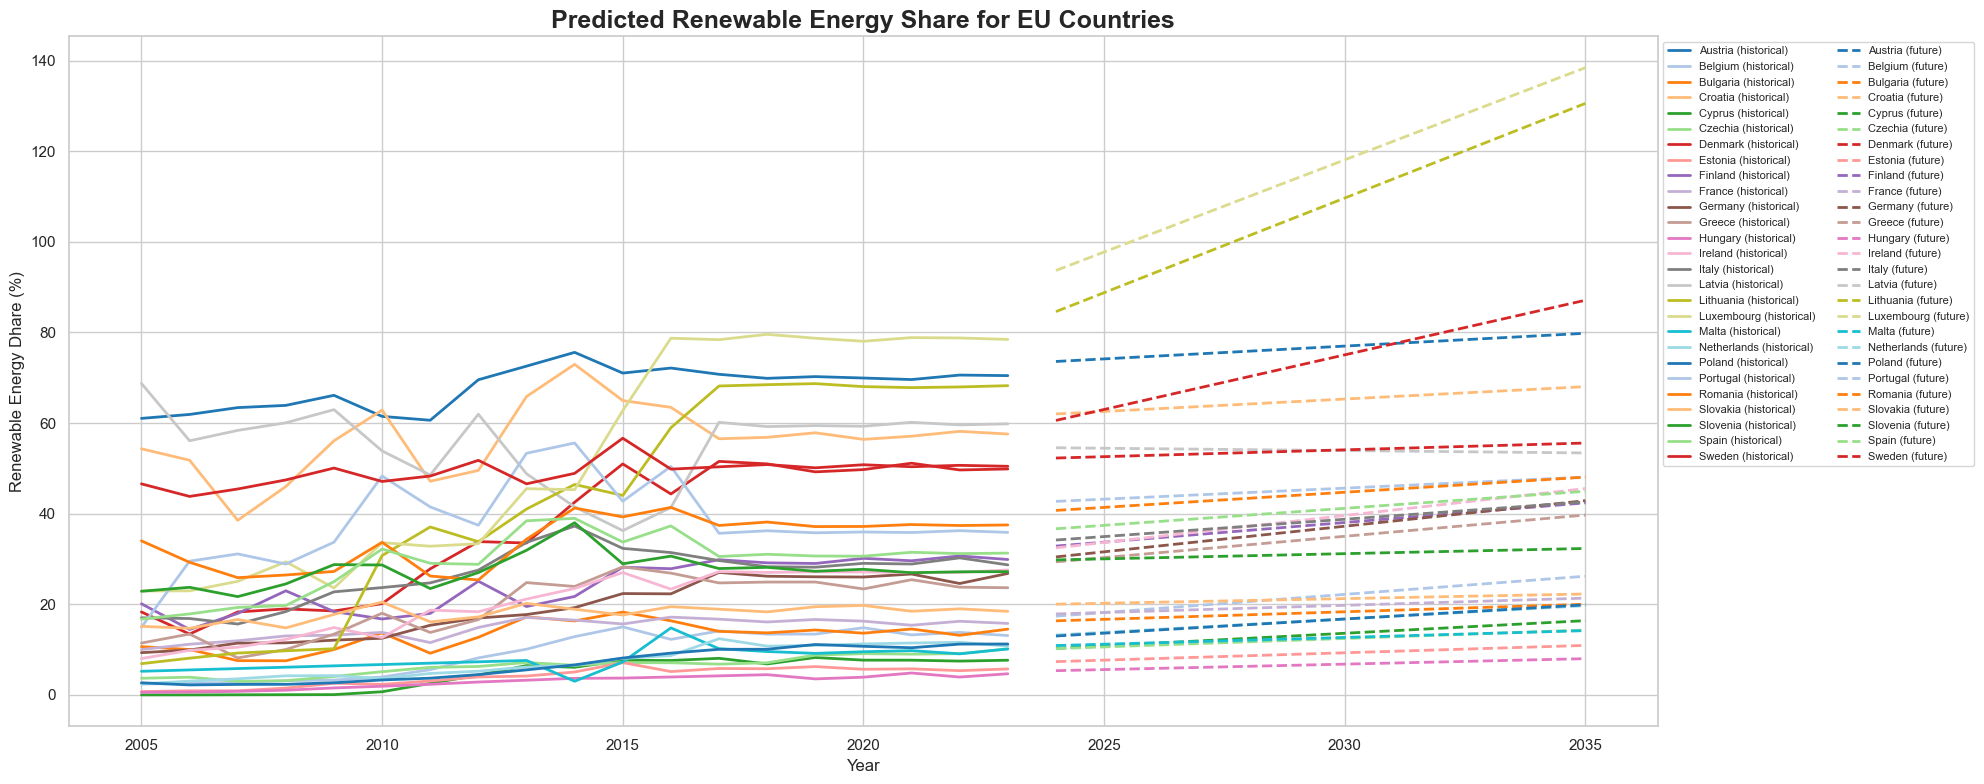

In [63]:
plot_historical_vs_predicted(df_hist=df_renw, df_pred=predictions, title='Predicted Renewable Energy Share for EU Countries', ylabel='Renewable Energy Dhare (%)', figsize=(20, 8))

In [64]:
print(metrics_df)

        Country      RMSE        R2
0       Austria  3.116639  0.496923
1       Belgium  2.051643  0.820725
2      Bulgaria  2.416969  0.362329
3       Croatia  7.069715  0.152781
4        Cyprus  1.408474  0.824316
5       Czechia  0.596186  0.921627
6       Denmark  5.202135  0.865690
7       Estonia  0.912999  0.791871
8       Finland  2.586226  0.771390
9        France  1.309668  0.638156
10      Germany  1.784761  0.923098
11       Greece  3.578838  0.673957
12      Hungary  0.486504  0.880485
13      Ireland  2.305087  0.888882
14        Italy  4.181062  0.500492
15       Latvia  8.208951  0.004794
16    Lithuania  6.826949  0.918235
17   Luxembourg  8.066665  0.884117
18        Malta  1.895627  0.427271
19  Netherlands  1.062002  0.901780
20       Poland  0.923317  0.932345
21     Portugal  8.847559  0.083304
22      Romania  3.919876  0.465446
23     Slovakia  1.321839  0.419423
24     Slovenia  3.327384  0.124719
25        Spain  4.948656  0.409091
26       Sweden  2.164760  0

#### Regressione Lineare Polinomiale

In [65]:
# Struttura dati per le predizioni
predictions_poly = pd.DataFrame({'Year' : range(2024, 2036)})

# Grado del polinomio
degree =  2

# DataFrame per memorizzare le metriche
metrics_df_poly = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello di regressione polinomiale per ogni paese 
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].fillna(0).values.flatten()
    
    # Trasformazione anni in formato polinomiale
    poly = PolynomialFeatures(degree=degree)
    years_poly = poly.fit_transform(years)

    # Addestramento modello
    model = LinearRegression()
    model.fit(years_poly, country_data)

    # Predizione sullo stesso set di dati
    y_pred = model.predict(years_poly)

    # Calcolo metriche
    mse = mean_squared_error(country_data, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(country_data, y_pred)

    # Salvataggio metriche
    metrics_df_poly.loc[len(metrics_df_poly)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

    # Predizione valori futuri
    future_years_poly = poly.transform(future_years)
    future_pred = model.predict(future_years_poly)

    # Impostazione valori negativi a zero
    future_pred = np.maximum(future_pred, 0)

    # Aggiunta presizioni al DF
    predictions[country] = future_pred


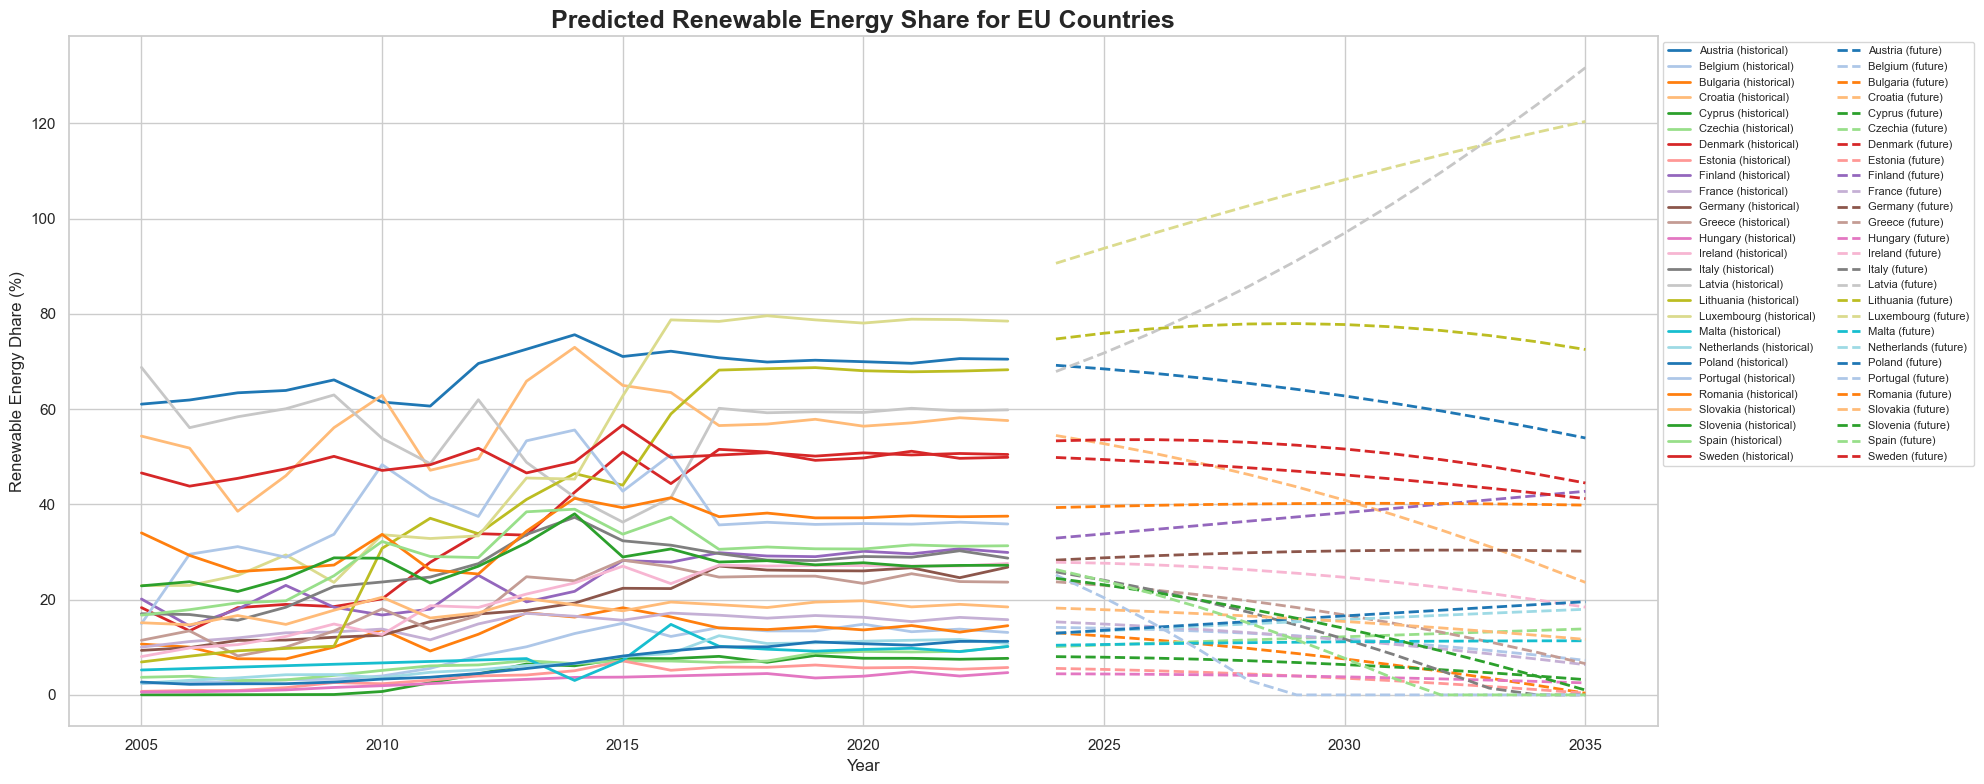

In [66]:
plot_historical_vs_predicted(df_hist=df_renw, df_pred=predictions, title='Predicted Renewable Energy Share for EU Countries', ylabel='Renewable Energy Dhare (%)', figsize=(20, 8))

In [67]:
print(metrics_df_poly)

        Country      RMSE        R2
0       Austria  2.623081  0.643643
1       Belgium  1.640243  0.885414
2      Bulgaria  2.051002  0.540816
3       Croatia  6.452748  0.294200
4        Cyprus  1.116464  0.889611
5       Czechia  0.595369  0.921842
6       Denmark  4.402418  0.903810
7       Estonia  0.601233  0.909744
8       Finland  2.586129  0.771407
9        France  0.871603  0.839736
10      Germany  1.581310  0.939631
11       Greece  2.856437  0.792298
12      Hungary  0.330057  0.944992
13      Ireland  1.483551  0.953973
14        Italy  2.689798  0.793267
15       Latvia  6.442078  0.387100
16    Lithuania  5.689029  0.943221
17   Luxembourg  7.980976  0.886566
18        Malta  1.886642  0.432687
19  Netherlands  1.056042  0.902879
20       Poland  0.923063  0.932382
21     Portugal  5.778199  0.609012
22      Romania  3.883088  0.475433
23     Slovakia  1.126115  0.578626
24     Slovenia  2.631395  0.452589
25        Spain  2.966265  0.787692
26       Sweden  1.951937  0

#### LSTM


In [82]:
# Parametri
sequence_length = 5 # lunghezza finestra temporale
future_steps = 12 # numero di anni futuri da predire

# Struttura dati per le predizioni
predictions = pd.DataFrame({'Year' : range(2024, 2024+future_steps)})

# DataFrame per memorizzare le metriche
metrics_df_lstm = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

# Addestramento di un modello LSTM per ogni paese 
for country in df_renw['Country']:
    # Estrazione dati storici per Paese
    country_data = df_renw[df_renw['Country']==country].iloc[0,1:].values.flatten()
    years = df_renw.columns[1:].astype(int)
    
    # Normalizzazione dei dati
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(country_data.reshape(-1,1)).flatten()

    # Sequenze temporali
    X,y = prepare_lstm_data(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Creazione modello
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Addestramento modello
    model.fit(X, y, epochs=100, batch_size=16, verbose=0)

    # Predizione valori futuri
    future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
    future_predictions = []

    for _ in range(future_steps):
        pred = model.predict(future_input, verbose=0)[0, 0]
        future_predictions.append(pred)
        future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)
    
    # Inversione della scalatura
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1)).flatten()

    # Aggiunta presizioni al DF
    predictions[country] = future_predictions

    # Calcolo metriche di valutazione
    y_train_pred_scaled = model.predict(X, verbose=0).flatten()
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1,1)).flatten()
    y_train = scaler.inverse_transform(y.reshape(-1,1)).flatten()

    mse = np.mean((y_train-y_train_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - (np.sum((y_train-y_train_pred) ** 2)) / np.sum((y_train-np.mean(y_train)) ** 2)

    # Salvataggio metriche
    metrics_df_lstm.loc[len(metrics_df_lstm)]={
        'Country':country,
        'RMSE':rmse,
        'R2':r2
    }

print(predictions.head())



c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola\Documents\CorsiAulab\Progetto finale\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Mariapaola

   Year    Austria    Belgium   Bulgaria    Croatia    Cyprus    Czechia  \
0  2024  70.334091  14.535457  14.490665  58.947933  8.128919  10.313090   
1  2025  70.327995  14.771036  14.506104  59.020489  8.099583  10.611093   
2  2026  70.364777  14.798139  14.569208  59.269226  8.148176  10.917394   
3  2027  70.465286  15.062303  14.570971  59.460705  8.192306  11.369645   
4  2028  70.445747  15.254628  14.661337  59.585930  8.312363  11.935841   

     Denmark   Estonia    Finland  ...  Luxembourg     Malta  Netherlands  \
0  52.890507  6.078904  31.417767  ...   84.127472  9.643262    12.401560   
1  53.463470  6.000209  31.895609  ...   85.314034  9.707791    12.678801   
2  54.087086  6.042363  32.210449  ...   86.787170  9.733605    12.957798   
3  54.466087  6.070590  32.732674  ...   88.250900  9.725662    13.270275   
4  55.338985  6.194130  33.124996  ...   89.942467  9.819787    13.644003   

      Poland   Portugal    Romania   Slovakia   Slovenia      Spain     Sweden  

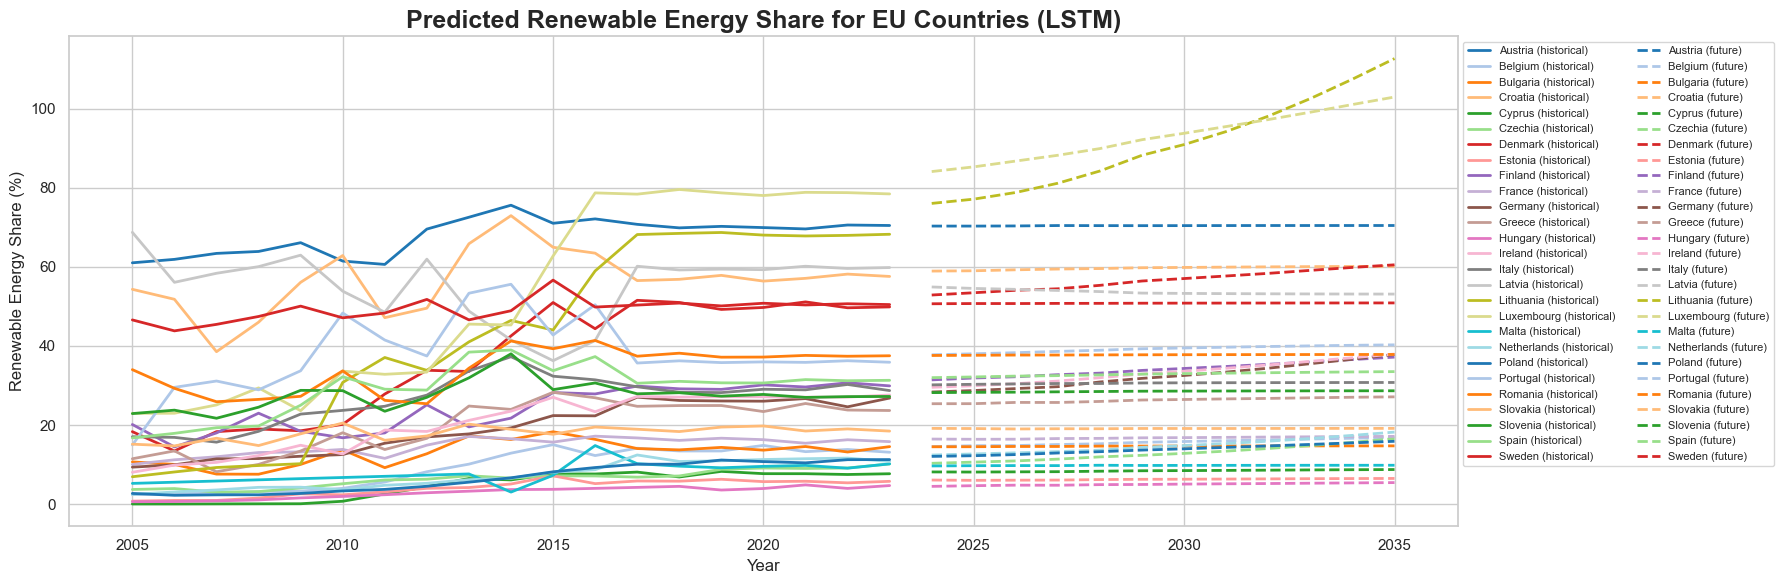

In [84]:
plt.figure(figsize=(18, 6))
sns.set_style("whitegrid")

countries = df_renw['Country']
palette = plt.cm.tab20.colors

color_map = {
    country: palette[i % len(palette)]
    for i, country in enumerate(countries)
}

years_pred = predictions['Year'].values

for country in countries:
    # Dati storici
    hist_values = df_renw[df_renw['Country'] == country].iloc[0, 1:].values.flatten()

    sns.lineplot(
        x=years,
        y=hist_values,
        color=color_map[country],
        linewidth=2,
        label=f'{country} (historical)'
    )

for country in predictions.columns[1:]:
    # Predizioni future
    sns.lineplot(
        x=years_pred,
        y=predictions[country],
        color=color_map[country],
        linestyle='--',
        linewidth=2,
        label=f'{country} (future)'
    )

plt.title(
    'Predicted Renewable Energy Share for EU Countries (LSTM)',
    fontsize=18,
    fontweight='bold'
)
plt.xlabel('Year')
plt.ylabel('Renewable Energy Share (%)')

plt.legend(
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=8
)

plt.tight_layout()
plt.show()

In [85]:
print(metrics_df_lstm)

        Country      RMSE        R2
0       Austria  3.518412  0.149154
1       Belgium  1.928151  0.665463
2      Bulgaria  2.095673  0.034904
3       Croatia  6.496900 -0.042195
4        Cyprus  1.226179  0.685396
5       Czechia  0.631274  0.794419
6       Denmark  5.340427  0.708407
7       Estonia  0.820302  0.563615
8       Finland  2.888243  0.634645
9        France  1.256341  0.240395
10      Germany  2.228442  0.777394
11       Greece  3.099451  0.372546
12      Hungary  0.422649  0.728120
13      Ireland  2.303447  0.731486
14        Italy  3.139092  0.108250
15       Latvia  8.084798  0.060532
16    Lithuania  6.865065  0.778850
17   Luxembourg  8.738232  0.796093
18        Malta  2.397183  0.092527
19  Netherlands  1.513661  0.721440
20       Poland  1.069027  0.859407
21     Portugal  8.236304 -0.358151
22      Romania  3.986143  0.257734
23     Slovakia  1.224486 -0.159113
24     Slovenia  3.215153 -0.017187
25        Spain  4.361105 -0.847092
26       Sweden  2.279639  0